# Import Libraries


In [1]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
import pickle
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random

2025-06-06 13:55:43.254199: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 13:55:43.479966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749192943.614837  201836 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749192943.647513  201836 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749192943.813290  201836 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Load Essay Dataset

In [2]:
stdset = pd.read_csv("datasets_ta/esai_siswa.csv")
gptset = pd.read_csv("datasets_ta/esai_gpt.csv")

In [3]:
stdset.info()
stdset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Essay   135 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB


,Essay
0,Selama berlibur dan bulan suci Ramadhan saya p...
1,selama bulan Ramadhan saya membantu orang tua ...
2,"Assalamualaikum, selama bulan suci Ramadhan sa..."
3,Selama libur idul Fitri sayaa hanya tidur teta...
4,Assalamu'alaikum warahmatullahi waabarakatuh \...


In [4]:
gptset.info()
gptset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Response  539 non-null    object
dtypes: object(1)
memory usage: 4.3+ KB


,Response
0,libur idul fitri tahun ini menjadi momen yang ...
1,"selain itu, teknologi juga membantuku dalam me..."
2,"tak lupa, teknologi juga memudahkan dalam menc..."
3,"secara keseluruhan, libur idul fitri ini menja..."
4,"selama libur idul fitri kali ini, teknologi me..."


In [5]:
def preprocess_text(text):
    """
    Text preprocessing:
    - Convert text to lowercase
    - Split text into sentences using regex
    - Keep final punctuation marks (., ?, !)

    Args:
        text (str): Input text.

    Returns:
        list: List of processed sentences.
    """
    if not isinstance(text, str) or text.strip() == "":
        return []

    text = text.lower().strip()
    sentences = re.findall(r'[^.!?]+[.!?]?', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    return sentences


# Load Dataset for Training

In [6]:
std_sen = []
gpt_sen = []  

for text in stdset['Essay']:
    std_sen.extend(preprocess_text(text))

for text in gptset['Response']:
    gpt_sen.extend(preprocess_text(text))

# Create DataFrames with text and labels
std_df = pd.DataFrame({'text': std_sen, 'label': 0})
gpt1_df = pd.DataFrame({'text': gpt_sen, 'label': 1})

# Combine all data
data = pd.concat([std_df, gpt1_df], ignore_index=True)

# Print statistics
print(f"Total student sentences: {len(std_sen)} (label=0)")
print(f"Total ChatGPT sentences: {len(gpt_sen)} (label=1)")
print(f"Total combined data: {len(data)}")

# Display first few rows of combined data
print("\nFirst few rows of combined data:")
pd.set_option('display.max_colwidth', None)
display(data.head())

Total student sentences: 1023 (label=0)
Total ChatGPT sentences: 2115 (label=1)
Total combined data: 3138

First few rows of combined data:


,text,label
0,"selama berlibur dan bulan suci ramadhan saya pulang kampung, setelah di kampung, saya sering ke masjid tarawih dan tadarusan bersama teman kampung saya, setelah tadarus kami melanjutkan dengan membangunkan sahur orang' di kampung, saya dan teman-teman sering bermain free fire sambil menunggu waktu berbuka,selain itu saya juga membantu bapak saya di kebun, kemudian di malam idul fitri saya dan orang kampung saya melakukan takbiran keliling kampung.",0
1,"selama bulan ramadhan saya membantu orang tua saya, saya juga mengikuti solat tarawih, buka bersama, saat lebaran saya bertemu teman dan keluarga saya, kami meminta maaf satu sama lainnya lalu kami berbincang""sebelumnya saya menunggu waktu berbuka sambil nnton tiktok dan rells ig.",0
2,"saya juga ikut melakukan kegiatan berbagi takjil bersama anggota osis di sekolah, kami melakukannya bersama"" kamu membuat es timun serut, lalu kami membagikannya di simpang tiga dekat dengan sekolah kami,",0
3,"assalamualaikum, selama bulan suci ramadhan saya sering pergi teraweh sama teman teman dan setelah teraweh saya melakukan tadarus, dan selama bulan suci ramadhan saya tinggal jauh sama orang tua tetapi orang tua saya datang saat idul fitri sudah dekat untuk melakukan idul fitri di sumbawa bersama saya setelah melakukan idul fitri saya mudik ke lombok bersama keluarga sekalian menikmati libur saat di di lombok saya juga pergi liburan ke mandalika dan setelah mau masuk sekolah saya kembali ke sumbawa untuk sekolah sekian dari saya terimakasih assalamualaikum",0
4,"selama libur idul fitri sayaa hanya tidur tetapi terkadang saya juga membantu mama saya membereskan rumah,lalu malamnyaa saya trawehh,sehabis trawe saya jalan' dngn teman' saya sambil mnunggu jam sahur,stelah jam sahur kami membangunkan orang sahur dengn menggunakan speaker.",0


# Data Splitting
- Training 75%
- Validation 5%
- Testing 20%

In [7]:
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['label']
)

print(f"Initial training set: {len(train_data)} samples")
print(f"Initial test set: {len(test_data)} samples")
print(f"Initial training distribution: Student={sum(train_data['label']==0)}, ChatGPT={sum(train_data['label']==1)}")
print(f"Initial test distribution: Student={sum(test_data['label']==0)}, ChatGPT={sum(test_data['label']==1)}")


X_train = train_data[['text']]
y_train = train_data['label']

undersampler = RandomUnderSampler(random_state=42)
X_train_indices = pd.DataFrame({'index': range(len(X_train))})
X_resampled_indices, y_resampled = undersampler.fit_resample(X_train_indices, y_train)

selected_indices = X_resampled_indices['index'].values

balanced_train_data = train_data.iloc[selected_indices].reset_index(drop=True)

removed_indices = set(range(len(train_data))) - set(selected_indices)
removed_samples = train_data.iloc[list(removed_indices)]

test_set = pd.concat([test_data, removed_samples]).reset_index(drop=True)
test_set = test_set.sort_values(by='label').reset_index(drop=True)

train_set, val_set = train_test_split(
    balanced_train_data, test_size=5/80, random_state=42, stratify=balanced_train_data['label']
)

train_set = train_set.sort_values(by='label').reset_index(drop=True)
val_set = val_set.sort_values(by='label').reset_index(drop=True)

# Print final dataset statistics
print("\nAfter undersampling:")
print(f"Training set: {len(train_set)} samples (Student={sum(train_set['label']==0)}, ChatGPT={sum(train_set['label']==1)})")
print(f"Validation set: {len(val_set)} samples (Student={sum(val_set['label']==0)}, ChatGPT={sum(val_set['label']==1)})")
print(f"Test set: {len(test_set)} samples (Student={sum(test_set['label']==0)}, ChatGPT={sum(test_set['label']==1)})")


Initial training set: 2510 samples
Initial test set: 628 samples
Initial training distribution: Student=818, ChatGPT=1692
Initial test distribution: Student=205, ChatGPT=423

After undersampling:
Training set: 1533 samples (Student=766, ChatGPT=767)
Validation set: 103 samples (Student=52, ChatGPT=51)
Test set: 1502 samples (Student=205, ChatGPT=1297)


# Initialize BERT Tokenizer

In [8]:
# Initialize IndoBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Tokenize function
def tokenize_text(texts, max_length=128):
    """
    Text tokenization using IndoBERT tokenizer.
    
    Args:
        texts (list): List of texts to be tokenized.
        max_length (int): Maximum token length.
        
    Returns:
        dict: Tokenized result, including input_ids and attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [9]:
# Tokenize student and ChatGPT essays
print("Tokenize student essay...")
std_tokens = tokenize_text(std_sen)
print("Tokenize ChatGPT essay...")
gpt_tokens = tokenize_text(gpt_sen)

print("Tokenize student essay (Training Set)...")
std_tr_tokens = tokenize_text(train_set[train_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Training Set)...")
gpt_tr_tokens = tokenize_text(train_set[train_set['label'] == 1]['text'].tolist())

print("Tokenize student essay (Validation Set)...")
std_va_tokens = tokenize_text(val_set[val_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Validation Set)...")
gpt_va_tokens = tokenize_text(val_set[val_set['label'] == 1]['text'].tolist())

print("Tokenize student essay (Test Set)...")
std_te_tokens = tokenize_text(test_set[test_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Test Set)...")
gpt_te_tokens = tokenize_text(test_set[test_set['label'] == 1]['text'].tolist())

# Display tokenization results (example: Student)
print("\nExample of tokenization results:")
print(std_tr_tokens['input_ids'][:3])  # Input token ID
print(std_tr_tokens['attention_mask'][:3])  # Attention mask

Tokenize student essay...


I0000 00:00:1749192950.411485  201836 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Tokenize ChatGPT essay...
Tokenize student essay (Training Set)...
Tokenize ChatGPT essay (Training Set)...
Tokenize student essay (Validation Set)...
Tokenize ChatGPT essay (Validation Set)...
Tokenize student essay (Test Set)...
Tokenize ChatGPT essay (Test Set)...

Example of tokenization results:
AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
tf.Tensor(
[[    2  1580   305   209   722  1614  1614   209  1821  3605    43   515
     34  3627    98  1258  1313 30470     3     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0  

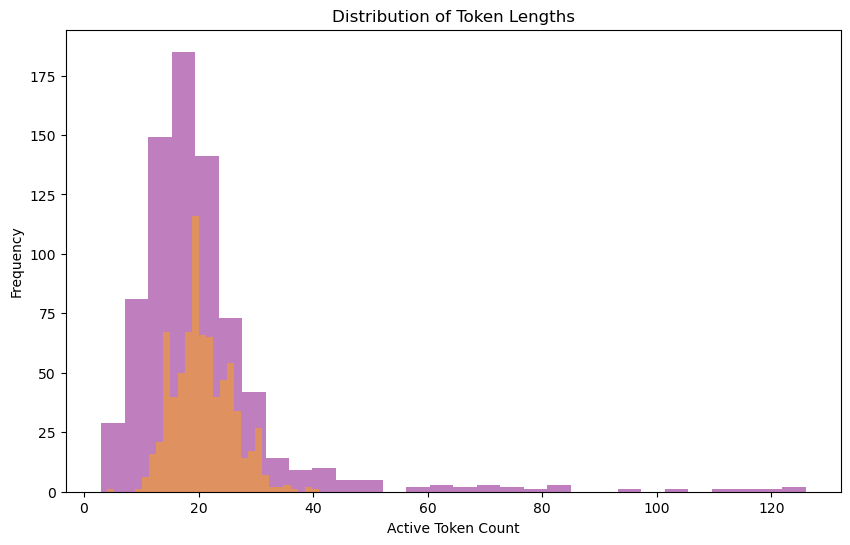

Average token length for Student: 20.78
Percentage truncated for Student: 0.00%
Average token length for ChatGPT: 20.79
Percentage truncated for ChatGPT: 0.00%


In [10]:
std_tr_lengths = [sum(mask) for mask in std_tr_tokens['attention_mask'].numpy()]
gpt_tr_lengths = [sum(mask) for mask in gpt_tr_tokens['attention_mask'].numpy()]

plt.figure(figsize=(10, 6))
plt.hist(std_tr_lengths, bins=30, alpha=0.5, label='Student', color='purple')
plt.hist(gpt_tr_lengths, bins=30, alpha=0.5, label='ChatGPT', color='orange')
plt.title('Distribution of Token Lengths')
plt.xlabel('Active Token Count')
plt.ylabel('Frequency')
plt.show()
print(f"Average token length for Student: {np.mean(std_tr_lengths):.2f}")
print(f"Percentage truncated for Student: {sum(l == 128 for l in std_tr_lengths) / len(std_tr_lengths) * 100:.2f}%")
print(f"Average token length for ChatGPT: {np.mean(gpt_tr_lengths):.2f}")
print(f"Percentage truncated for ChatGPT: {sum(l == 128 for l in gpt_tr_lengths) / len(gpt_tr_lengths) * 100:.2f}%")

In [11]:
# Decoding tokens for ensuring correctness
sample_text = gpt_sen[0]
sample_tokens = tokenizer.encode(sample_text)
print(f"Sample Text: {sample_text}")
print(f"Token ID: {sample_tokens}")
print(f"Token dekode: {tokenizer.decode(sample_tokens)}")

Sample Text: libur idul fitri tahun ini menjadi momen yang sangat dinantikan oleh semua orang, termasuk aku.
Token ID: [2, 7676, 8616, 8109, 262, 92, 234, 7585, 34, 310, 22766, 828, 213, 366, 232, 30468, 1087, 304, 30470, 3]
Token dekode: [CLS] libur idul fitri tahun ini menjadi momen yang sangat dinantikan oleh semua orang, termasuk aku. [SEP]


In [12]:
# Save tokenized data
tokenized_data = {
    'student': std_tokens,
    'chatgpt': gpt_tokens
}

# Save input_ids and attention_mask as numpy arrays
tokenized_numpy = {
    'student': {
        'input_ids': std_tokens['input_ids'].numpy(),
        'attention_mask': std_tokens['attention_mask'].numpy()
    },
    'chatgpt ': {
        'input_ids': gpt_tokens ['input_ids'].numpy(),
        'attention_mask': gpt_tokens ['attention_mask'].numpy()
    }
}

os.makedirs("ta_sentence", exist_ok=True)

with open('ta_sentence/tokenized_data.pkl', 'wb') as f:
    pickle.dump(tokenized_numpy, f)

# Build IndoBERT Semantic Similarity Model

In [13]:
# Load IndoBERT model
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

# Define Bi-Encoder model
def model(bert_model):
    """
    Create a Bi-Encoder model with IndoBERT.
    
    Args:
        bert_model (TFBertModel): Base model of IndoBERT.
        
    Returns:
        tf.keras.Model: Bi-Encoder model.
    """
    # Input layer
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")
    
    # Extract CLS token embeddings from IndoBERT
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]  # [CLS] token
    
    # Dense layer for fine-tuning
    dense1 = tf.keras.layers.Dense(128, activation="relu")(bert_output)
    dropout1 = tf.keras.layers.Dropout(0.1)(dense1)
    dense2 = tf.keras.layers.Dense(128, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.1)(dense2)
    dense3 = tf.keras.layers.Dense(128)(dropout2)
    
    # Output normalization (L2 normalization)
    normalized_output = tf.nn.l2_normalize(dense3, axis=1)
    
    # Semantic model
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=normalized_output)

# Build model
semantic_model = model(bert_model)

# Show model summary
print("Model Summary:")
semantic_model.summary()


Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                        

# Create Contrastive Pairs

In [14]:
def create_contrastive_pairs(student_tokens, chatgpt_tokens, max_pairs=None):
    """
    Creates data pairs for contrastive learning with dataset-appropriate quantities.

    Args:
        student_tokens: Tokenized student text
        chatgpt_tokens_1: First set of tokenized ChatGPT text
        chatgpt_tokens_2: Second set of tokenized ChatGPT text
        max_pairs: Maximum number of pairs (optional). If None, uses all possible combinations.

    Returns:
        tuple: Dictionary of anchor, positive, negative pairs and labels, and the total number of pairs.
    """
    # Get dataset sizes
    n_student = student_tokens['input_ids'].shape[0]
    n_chatgpt = chatgpt_tokens['input_ids'].shape[0]
    
    # Calculate maximum possible combinations
    max_student_pairs = (n_student * (n_student - 1)) // 2  # student-student combinations
    max_chatgpt_pairs = (n_chatgpt * (n_chatgpt - 1)) // 2  # chatgpt-chatgpt combinations
    max_negative_pairs = n_student * n_chatgpt  # student-chatgpt combinations
    
    # Determine number of pairs to create
    if max_pairs is None:
        # Use minimum number of positive pairs for balance
        n_pos_student = min(max_student_pairs, max_chatgpt_pairs) // 2
        n_pos_chatgpt = n_pos_student
        # Limit negative pairs to balance with positives
        n_neg_pairs = min(max_negative_pairs, 2 * n_pos_student)
    else:
        # If max_pairs is specified, use that with equal proportions
        n_pos_student = max_pairs // 4
        n_pos_chatgpt = max_pairs // 4
        n_neg_pairs = max_pairs // 2
    
    # Ensure we don't exceed the maximum possible combinations
    n_pos_student = min(n_pos_student, max_student_pairs)
    n_pos_chatgpt = min(n_pos_chatgpt, max_chatgpt_pairs)
    n_neg_pairs = min(n_neg_pairs, max_negative_pairs)
    
    # Initialize arrays for data pairs
    anchor_input_ids = []
    anchor_attention_mask = []
    positive_input_ids = []
    positive_attention_mask = []
    negative_input_ids = []
    negative_attention_mask = []
    labels = []
    
    # Generate positive student-student pairs
    if n_pos_student > 0:
        # Create all possible student-student pairs
        student_pairs = [(i, j) for i in range(n_student) for j in range(i+1, n_student)]
        # Randomly select pairs
        selected_pairs = random.sample(student_pairs, n_pos_student)
        
        for idx1, idx2 in selected_pairs:
            # Anchor (student)
            anchor_input_ids.append(student_tokens['input_ids'][idx1])
            anchor_attention_mask.append(student_tokens['attention_mask'][idx1])
            
            # Positive (another student)
            positive_input_ids.append(student_tokens['input_ids'][idx2])
            positive_attention_mask.append(student_tokens['attention_mask'][idx2])
            
            # Negative (from ChatGPT)
            neg_idx = np.random.choice(n_chatgpt)
            negative_input_ids.append(chatgpt_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(chatgpt_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate positive chatgpt-chatgpt pairs
    if n_pos_chatgpt > 0:
        # Create all possible chatgpt-chatgpt pairs
        chatgpt_pairs = [(i, j) for i in range(n_chatgpt) for j in range(i+1, n_chatgpt)]
        # Randomly select pairs
        selected_pairs = random.sample(chatgpt_pairs, n_pos_chatgpt)
        
        for idx1, idx2 in selected_pairs:
            # Anchor
            anchor_input_ids.append(chatgpt_tokens['input_ids'][idx1])
            anchor_attention_mask.append(chatgpt_tokens['attention_mask'][idx1])
            
            # Positive
            positive_input_ids.append(chatgpt_tokens['input_ids'][idx2])
            positive_attention_mask.append(chatgpt_tokens['attention_mask'][idx2])
            
            # Negative (from Student)
            neg_idx = np.random.choice(n_student)
            negative_input_ids.append(student_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(student_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate negative student-chatgpt pairs
    if n_neg_pairs > 0:
        # Create all possible student-chatgpt pairs
        negative_pairs = [(i, j) for i in range(n_student) for j in range(n_chatgpt)]
        # Randomly select pairs
        selected_pairs = random.sample(negative_pairs, n_neg_pairs)
        
        for student_idx, chatgpt_idx in selected_pairs:
            # Anchor (Student)
            anchor_input_ids.append(student_tokens['input_ids'][student_idx])
            anchor_attention_mask.append(student_tokens['attention_mask'][student_idx])
            
            # Negative (ChatGPT)
            negative_input_ids.append(chatgpt_tokens['input_ids'][chatgpt_idx])
            negative_attention_mask.append(chatgpt_tokens['attention_mask'][chatgpt_idx])
            
            # Positive (another Student different from anchor)
            available_pos = [i for i in range(n_student) if i != student_idx]
            if available_pos:  # Ensure there are available indices
                pos_idx = np.random.choice(available_pos)
                positive_input_ids.append(student_tokens['input_ids'][pos_idx])
                positive_attention_mask.append(student_tokens['attention_mask'][pos_idx])
                
                # Label (0 for negative pair)
                labels.append(0)
    
    # Count actual pairs created
    actual_pairs = len(labels)
    
    # Convert to tensors and return
    return {
        'anchor': {
            'input_ids': tf.convert_to_tensor(anchor_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(anchor_attention_mask, dtype=tf.int32)
        },
        'positive': {
            'input_ids': tf.convert_to_tensor(positive_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(positive_attention_mask, dtype=tf.int32)
        },
        'negative': {
            'input_ids': tf.convert_to_tensor(negative_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(negative_attention_mask, dtype=tf.int32)
        },
        'labels': tf.convert_to_tensor(labels, dtype=tf.float32)
    }, actual_pairs

In [15]:
# Create contrastive pairs
std_gpt_tr_pairs, total_pairs_tr = create_contrastive_pairs(std_tr_tokens, gpt_tr_tokens, max_pairs=250000)
std_gpt_va_pairs, total_pairs_va = create_contrastive_pairs(std_va_tokens, gpt_va_tokens, max_pairs=250000)

# Show the number of pairs created
print(f"Total contrastive pairs (training) created: {total_pairs_tr}")
print(f"- Positive pairs student-student: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Positive pairs chatgpt-chatgpt: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Negative pairs student-chatgpt: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 0)}")


Total contrastive pairs (training) created: 250000
- Positive pairs student-student: 62500
- Positive pairs chatgpt-chatgpt: 62500
- Negative pairs student-chatgpt: 125000


# Build Triplet Model

In [16]:
# Model for training with triplet loss
def triplet_model(semantic_model):
    """
    Build a model for training with triplet loss.
    
    Args:
        semantic_model: The semantic similarity model to be trained.
        
    Returns:
         tf.keras.Model: Model for training with triplet loss.
    """
    # Input for anchor, positive, and negative
    anchor_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="anchor_input_ids")
    anchor_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="anchor_attention_mask")
    
    positive_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="positive_input_ids")
    positive_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="positive_attention_mask")
    
    negative_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="negative_input_ids")
    negative_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="negative_attention_mask")
    
    # Embedding for anchor, positive, and negative
    anchor_embedding = semantic_model([anchor_input_ids, anchor_attention_mask])
    positive_embedding = semantic_model([positive_input_ids, positive_attention_mask])
    negative_embedding = semantic_model([negative_input_ids, negative_attention_mask])
    
    # measure cosine similarity
    pos_similarity = tf.reduce_sum(anchor_embedding * positive_embedding, axis=1)
    neg_similarity = tf.reduce_sum(anchor_embedding * negative_embedding, axis=1)
    
    # Model output is the similarity score
    output = tf.stack([pos_similarity, neg_similarity], axis=1)
    
    return tf.keras.Model(
        inputs=[
            anchor_input_ids, anchor_attention_mask,
            positive_input_ids, positive_attention_mask,
            negative_input_ids, negative_attention_mask
        ],
        outputs=output
    )

# Triplet Loss Function

In [17]:
# Triplet loss function
def triplet_loss(y_true, y_pred):
    """
    Triplet loss: tunes the network such that
the distance between a and p is smaller than the
distance between a and n.
    
    Args:
        y_true: not used triplet loss.
        y_pred: stack of [positive_similarity, negative_similarity].
        
    Returns:
        tf.Tensor: loss value.
    """
    pos_sim = y_pred[:, 0]
    neg_sim = y_pred[:, 1]
    margin = 0.5
    
    # Triplet loss: max(0, margin - (pos_sim - neg_sim))
    loss = tf.maximum(0., margin - (pos_sim - neg_sim))
    return tf.reduce_mean(loss)

# Train IndoBERT Semantic Similarity Model

In [18]:
# Build triplet model for student vs ChatGPT essay
build_triplet = triplet_model(semantic_model)

# Compile model
build_triplet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=triplet_loss
)

# Training model Student_ChatGPT
print("Training model...")
history = build_triplet.fit(
    x=[
        std_gpt_tr_pairs['anchor']['input_ids'],
        std_gpt_tr_pairs['anchor']['attention_mask'],
        std_gpt_tr_pairs['positive']['input_ids'],
        std_gpt_tr_pairs['positive']['attention_mask'],
        std_gpt_tr_pairs['negative']['input_ids'],
        std_gpt_tr_pairs['negative']['attention_mask']
    ],
    y=std_gpt_tr_pairs['labels'], 
    epochs=10,
    batch_size=16,
    validation_data=(
    [
        std_gpt_va_pairs['anchor']['input_ids'],
        std_gpt_va_pairs['anchor']['attention_mask'],
        std_gpt_va_pairs['positive']['input_ids'],
        std_gpt_va_pairs['positive']['attention_mask'],
        std_gpt_va_pairs['negative']['input_ids'],
        std_gpt_va_pairs['negative']['attention_mask']
    ],
    std_gpt_va_pairs['labels']
    ),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Training model...
Epoch 1/10


I0000 00:00:1749193142.987877  201987 service.cc:152] XLA service 0x7f2da93ce230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749193142.987907  201987 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-06-06 13:59:02.992665: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749193143.005373  201987 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749193143.090842  201987 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15625/15625 [==============================] - 3178s 203ms/step - loss: 0.2000 - val_loss: 0.2595
Epoch 2/10
15625/15625 [==============================] - 3177s 203ms/step - loss: 0.0836 - val_loss: 0.2629
Epoch 3/10
15625/15625 [==============================] - 2952s 189ms/step - loss: 0.0441 - val_loss: 0.2924


# Training History

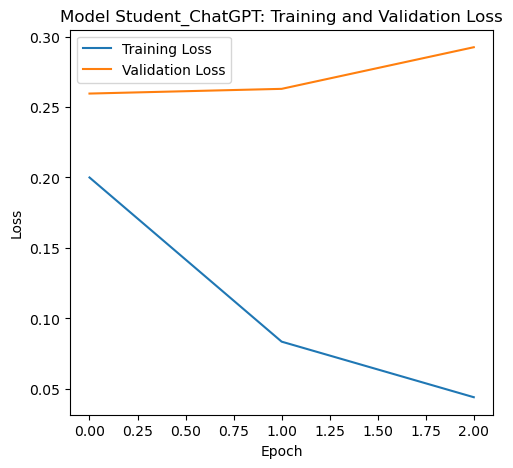

In [19]:
# Plot training history untuk model Student_ChatGPT
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Student_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Generate Embeddings Function

In [20]:
def gen_emb(tokens, model, batch_size=32):
    """
    Generate embeddings using IndoBERT in batches.
    
    Args:
        tokens: Token from text.
        model: IndoBERT Semantic Similarity.
        batch_size: Number of samples per batch.
        
    Returns:
        np.ndarray: Embeddings.
    """
    embeddings = []
    
    num_batches = len(tokens['input_ids']) // batch_size + (len(tokens['input_ids']) % batch_size > 0)
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(tokens['input_ids']))

        batch_input_ids = tokens['input_ids'][start_idx:end_idx]
        batch_attention_mask = tokens['attention_mask'][start_idx:end_idx]
        
        batch_embeddings = model([batch_input_ids, batch_attention_mask])
        
        embeddings.append(batch_embeddings)
    
    return np.concatenate(embeddings, axis=0)

# Cosine Similarity Function

In [21]:
def cos_sim(embedding1, embedding2):
    """
    Calculate similarity score using standard cosine similarity.
    
    Args:
        embedding1: First embedding (input text)
        embedding2: Second embedding (reference)
        
    Returns:
        float: Average cosine similarity score
    """
    embedding1_norm = tf.nn.l2_normalize(embedding1, axis=-1)
    embedding2_norm = tf.nn.l2_normalize(embedding2, axis=-1)
    
    similarities = tf.matmul(embedding1_norm, tf.transpose(embedding2_norm))
    similarities = tf.reshape(similarities, [-1])

    avg_similarity = tf.reduce_mean(similarities).numpy()
    return avg_similarity


# Generate Embeddings (All Text)

In [22]:
# Generate embeddings for all text
print("Generating embeddings for Student (all text)...")
std_emb = gen_emb(std_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (all text)...")
gpt_emb = gen_emb(gpt_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (all text)...
Generating embeddings for ChatGPT (all text)...


# Measure Similarity Score (All Text)

In [23]:
std_std_sim_scores = []
std_gpt_sim_scores = []
for emb in std_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_sim_scores.append(avg_similarity)

gpt_std_sim_scores = []
gpt_gpt_sim_scores = []
for emb in gpt_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_sim_scores.append(avg_similarity)

std_sim_scores = np.array([
    std_std_sim_scores, 
    std_gpt_sim_scores
])

gpt_sim_scores = np.array([
    gpt_std_sim_scores, 
    gpt_gpt_sim_scores
])

# Visualization of Similarity Score (All Text)

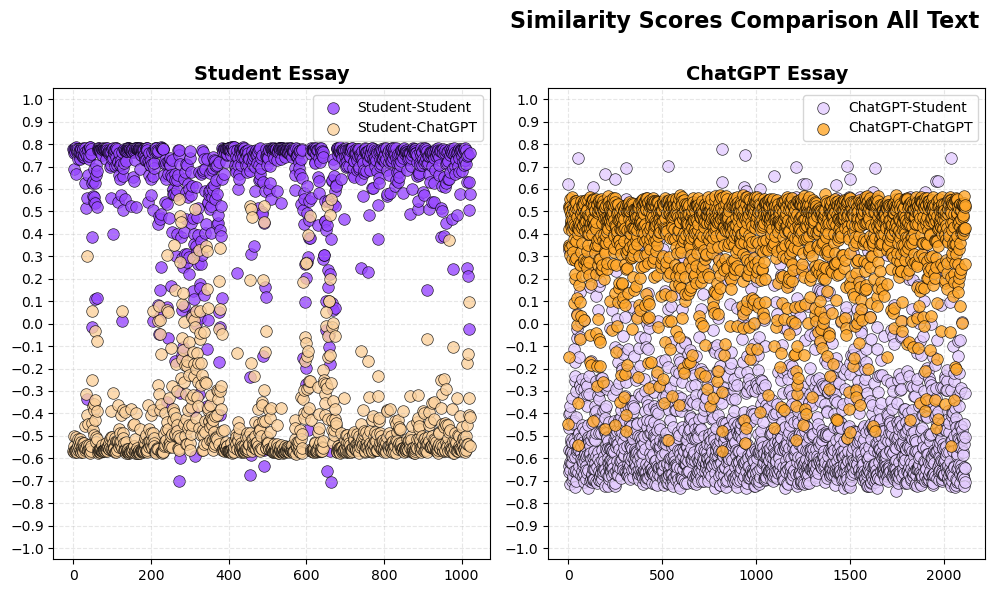

In [24]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student
plt.subplot(1, 3, 1)
plt.scatter(range(len(std_std_sim_scores)), std_std_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(std_gpt_sim_scores)), std_gpt_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: ChatGPT
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt_std_sim_scores)), gpt_std_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt_gpt_sim_scores)), gpt_gpt_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Similarity Scores Comparison All Text', fontsize=16, fontweight='bold', y=0.98, ha='center')
plt.tight_layout()
plt.subplots_adjust(top=0.85)  

os.makedirs('ta_sentence/images', exist_ok=True)
plt.savefig('ta_sentence/images/similarity_scores_comparison(all).png', dpi=300, bbox_inches='tight')

plt.show()

# Generate Embeddings (Test Set)

In [25]:
# Generate embeddings for data test
print("Generating embeddings for Student (test set)...")
std_te_emb = gen_emb(std_te_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (test set)...")
gpt_te_emb = gen_emb(gpt_te_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (test set)...
Generating embeddings for ChatGPT (test set)...


# Measure Similarity Score (Test Set)

In [26]:
std_std_te_sim_scores = []
std_gpt_te_sim_scores = []
for emb in std_te_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_te_sim_scores.append(avg_similarity)

gpt_std_te_sim_scores = []
gpt_gpt_te_sim_scores = []
for emb in gpt_te_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_te_sim_scores.append(avg_similarity)

std_te_sim_scores = np.array([
    std_std_te_sim_scores, 
    std_gpt_te_sim_scores
])

gpt_te_sim_scores = np.array([
    gpt_std_te_sim_scores, 
    gpt_gpt_te_sim_scores
])

# Similarity Text Breakdown (Test Set)

In [27]:
test_pairs = []
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.width', 1000)        
pd.set_option('display.max_rows', None)      

for i, student_text in enumerate(std_sen):
    if i >= len(std_te_emb):
        continue
        
    student_embedding = tf.expand_dims(std_te_emb[i], 0)

    for j in range(len(gpt_sen)):
        if j >= len(gpt_te_emb):
            continue

        chatgpt_embedding = tf.expand_dims(gpt_te_emb[j], 0)
        similarity = cos_sim(student_embedding, chatgpt_embedding)
        
        test_pairs.append({
            'student_idx': i,
            'chatgpt_idx': j,
            'student_text': student_text,
            'chatgpt_text': gpt_sen[j],
            'similarity_score': similarity
        })

sorted_pairs = sorted(test_pairs, key=lambda x: x['similarity_score'], reverse=True)

result_v1 = sorted_pairs[:5]

df_v1 = pd.DataFrame(result_v1)[['student_text', 'chatgpt_text', 'similarity_score']]
df_v1.columns = ['Student Essay', 'ChatGPT Essay', 'Similarity Score']

print("=== 1: Standard ===")
display(df_v1)

used_student_indices_v2 = set()
used_chatgpt_indices_v2 = set()
result_v2 = []

for pair in sorted_pairs:
    if (pair['student_idx'] in used_student_indices_v2 or 
        pair['chatgpt_idx'] in used_chatgpt_indices_v2):
        continue
    result_v2.append(pair)
    used_student_indices_v2.add(pair['student_idx'])
    used_chatgpt_indices_v2.add(pair['chatgpt_idx'])
    if len(result_v2) >= 5:
        break

df_v2 = pd.DataFrame(result_v2)[['student_text', 'chatgpt_text', 'similarity_score']]
df_v2.columns = ['Student Essay', 'ChatGPT Essay', 'Similarity Score']

print("=== 2: Unique ===")
display(df_v2)

=== 1: Standard ===


,Student Essay,ChatGPT Essay,Similarity Score
0,saya berharap dapat terus memanfaatkan teknologi untuk meningkatkan kemampuan saya dan mencapai tujuan saya di masa depan.,"dengan teknologi, meskipun liburan, belajar tetap dapat dilakukan secara fleksibel dan menyenangkan, kapan saja dan di mana saja.",0.982048
1,setelah membangunkan sahur saya lanjutkan sholat subuh balik dari masjid saya lanjut tidur dan saya bangun kesiangan sekitar jam 12.,"dengan teknologi, meskipun liburan, belajar tetap dapat dilakukan secara fleksibel dan menyenangkan, kapan saja dan di mana saja.",0.980095
2,"selain itu, saya juga menggunakan teknologi untuk belajar hal-hal baru selama liburan.","dengan teknologi, meskipun liburan, belajar tetap dapat dilakukan secara fleksibel dan menyenangkan, kapan saja dan di mana saja.",0.978639
3,"karena gak semua orang bisa ketemu langsung, jadi lebih asik kalau bisa tetep ngobrol dan update lewat chat.","dengan teknologi, meskipun liburan, belajar tetap dapat dilakukan secara fleksibel dan menyenangkan, kapan saja dan di mana saja.",0.976606
4,"eh, pas lagi asik ngobrol, tiba-tiba saudara pada kasih thr, walau sekarang udah mulai ngasih, bukan nerima lagi.","dengan teknologi, meskipun liburan, belajar tetap dapat dilakukan secara fleksibel dan menyenangkan, kapan saja dan di mana saja.",0.976380


=== 2: Unique ===


,Student Essay,ChatGPT Essay,Similarity Score
0,saya berharap dapat terus memanfaatkan teknologi untuk meningkatkan kemampuan saya dan mencapai tujuan saya di masa depan.,"dengan teknologi, meskipun liburan, belajar tetap dapat dilakukan secara fleksibel dan menyenangkan, kapan saja dan di mana saja.",0.982048
1,"setelah solat subuh biasanya saya ngaji terlebih dahulu,setelah sy ngaji saya pergi nongkrong bersama teman teman dan bermain mobile legends bareng/mabar sampai jam 11.","saya menghabiskan waktu dengan menjelajahi berbagai konten edukatif di youtube, dari tutorial masak hingga sejarah idul fitri di berbagai negara.",0.960167
2,assalamu'alaikum warahmatullahi waabarakatuh.,berbagai platform online seperti coursera dan youtube menawarkan banyak sekali kursus gratis yang sangat bermanfaat.,0.958769
3,"opor, rendang, ketupat semua makanan enak ada di meja, dan nggak boleh lupa dokumentasi pake hp biar bisa di-post di discord buat share ke temen-temen.","selain untuk menghibur, teknologi juga dapat digunakan untuk belajar dan berkomunikasi dengan orang-orang tercinta.",0.958661
4,"saya akan menceritakan tentang kegiatan saya di bulan suci ramadhan \nselama 20 hari saya berpuasa di sumabwa, dan di hari tersebut saya pulang kampung dan sholat 5 waktu beserta dengan sholat isya badyah dan traweh,tadarus,lalu saya main geme fre fire yg seperti perang dunia ketiga yg terkenal si dunia.","liburan kali ini mengingatkan saya bahwa meskipun teknik merayakan berubah, esensi dari idul fitri tidak hilang.",0.953049


# Visualization of Similarity Score (Test Set)

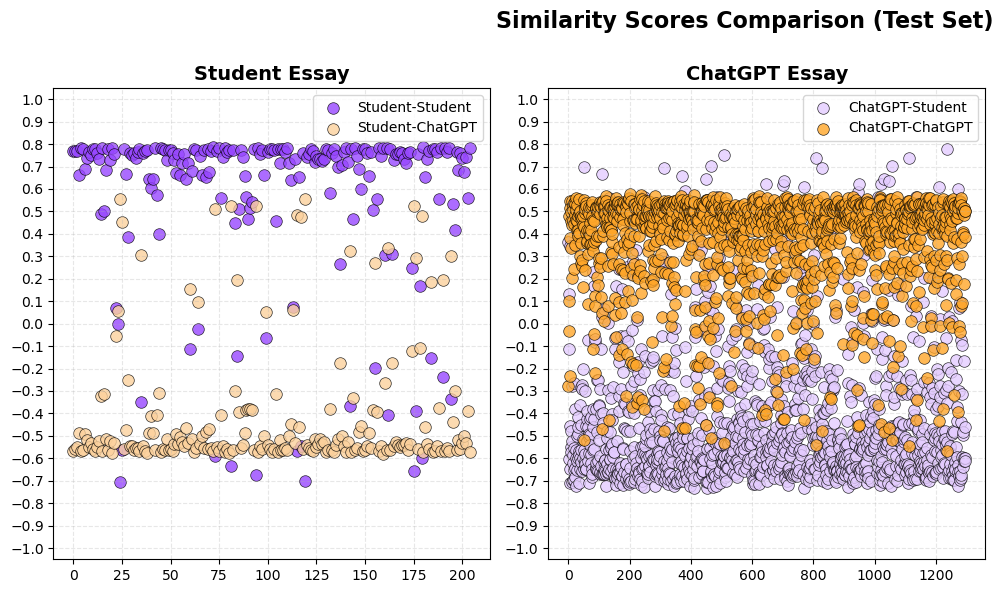

In [28]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student
plt.subplot(1, 3, 1)
plt.scatter(range(len(std_std_te_sim_scores)), std_std_te_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(std_gpt_te_sim_scores)), std_gpt_te_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: ChatGPT
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt_std_te_sim_scores)), gpt_std_te_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt_gpt_te_sim_scores)), gpt_gpt_te_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Similarity Scores Comparison (Test Set)', fontsize=16, fontweight='bold', y=0.98, ha='center')
plt.tight_layout()
plt.subplots_adjust(top=0.85)  

plt.savefig('ta_sentence/images/similarity_scores_comparison(test).png', dpi=300, bbox_inches='tight')

plt.show()

# Generate Embeddings (Training & Validation Sets)

In [29]:
# Generate embeddings for training and validation sets
print("Generating embeddings for Student (training set)...")
std_tr_emb = gen_emb(std_tr_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (training set)...")
gpt_tr_emb = gen_emb(gpt_tr_tokens, semantic_model, batch_size=32)

print("Generating embeddings for Student (validation set)...")
std_va_emb = gen_emb(std_va_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (validation set)...")
gpt_va_emb = gen_emb(gpt_va_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (training set)...
Generating embeddings for ChatGPT (training set)...
Generating embeddings for Student (validation set)...
Generating embeddings for ChatGPT (validation set)...


# Measure Similarity Score (Training & Validation Sets)

In [30]:
# Training set
std_std_tr_sim_scores = []
std_gpt_tr_sim_scores = []
for emb in std_tr_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_tr_sim_scores.append(avg_similarity)

gpt_std_tr_sim_scores = []
gpt_gpt_tr_sim_scores = []
for emb in gpt_tr_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_tr_sim_scores.append(avg_similarity)

std_tr_sim_scores = np.array([
    std_std_tr_sim_scores, 
    std_gpt_tr_sim_scores
])

gpt_tr_sim_scores = np.array([
    gpt_std_tr_sim_scores, 
    gpt_gpt_tr_sim_scores
])

# Validation set
std_std_va_sim_scores = []
std_gpt_va_sim_scores = []
for emb in std_va_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_va_sim_scores.append(avg_similarity)

gpt_std_va_sim_scores = []
gpt_gpt_va_sim_scores = []
for emb in gpt_va_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_va_sim_scores.append(avg_similarity)

std_va_sim_scores = np.array([
    std_std_va_sim_scores, 
    std_gpt_va_sim_scores
])

gpt_va_sim_scores = np.array([
    gpt_std_va_sim_scores, 
    gpt_gpt_va_sim_scores
])

# Define Linguistic Features

In [31]:
def linguistic_features(text):
    """
    Features extraction from text:
    1.	Lexical Diversity
    2.	Total words in the essay
    3.	Total unique words*
    4.	Modals
    5.	Stopwords ratio*

    
    Args:
        text (str): Input text.
        
    Returns:
        dict: Linguistic features.
    """
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    word_count = len(words)
    unique_count = len(set(words))
    
    ld = (unique_count / word_count * 100) if word_count > 0 else 0
    
    # Load modals from corpus file
    modals = set()
    if os.path.exists('corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv'):
        with open('corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv', 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    parts = line.strip().split('\t')
                    if len(parts) >= 2 and parts[1] == 'MD':
                        modals.add(parts[0].lower())
    
    # Count modals in text
    modal_count = sum(1 for word in words if word.lower() in modals)
    
    # Load stopwords from file
    stopwords = set()
    if os.path.exists('corpus/stopwords.txt'):
        with open('corpus/stopwords.txt', 'r', encoding='utf-8') as f:
            for line in f:
                stopwords.add(line.strip())
    
    # Calculate stopword ratio
    stopword_count = sum(1 for word in words if word.lower() in stopwords)
    stopword_ratio = (stopword_count / word_count * 100) if word_count > 0 else 0

    return {
        'lexical_diversity': ld,
        'total_words': word_count,
        'total_unique_words': unique_count,
        'modals': modal_count,
        'stopwords_ratio': stopword_ratio,
    }

# Features Extraction (All Text)

In [32]:
# Feature extraction for Student and ChatGPT essays
print("Features extraction for Student...")
std_features = [linguistic_features(text) for text in std_sen]

print("Features extraction for ChatGPT...")
gpt_features = [linguistic_features(text) for text in gpt_sen]


# convert
std_features_df = pd.DataFrame(std_features)
gpt_features_df = pd.DataFrame(gpt_features)


# Show the first few rows of the features DataFrames
print("\nStudent Linguistic Features:")
display(std_features_df.head())

print("\nChatGPT Linguistic Features:")
display(gpt_features_df.head())

Features extraction for Student...
Features extraction for ChatGPT...

Student Linguistic Features:


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio
0,66.176471,68,45,0,50.000000
1,83.720930,43,36,0,53.488372
2,83.333333,30,25,0,56.666667
3,54.651163,86,47,2,54.651163
4,82.926829,41,34,0,31.707317



ChatGPT Linguistic Features:


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio
0,100.000000,15,15,0,60.000000
1,100.000000,15,15,1,53.333333
2,100.000000,21,21,1,57.142857
3,93.750000,16,15,0,56.250000
4,92.857143,14,13,3,71.428571


# Normalize Linguistic Features (All Text)

In [33]:
# Combine features into a single DataFrame
all_features = pd.concat([std_features_df, gpt_features_df], axis=0)

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

# Separate normalized features back into student and ChatGPT
n_student = len(std_features_df)
n_chatgpt = len(gpt_features_df)

std_features_norm = normalized_features[:n_student]
gpt_features_norm = normalized_features[n_student:n_student + n_chatgpt]

print("Student features after normalization:")
print(std_features_norm[:5])

print("ChatGPT features after normalization:")
print(gpt_features_norm[:5])

# Save scaler for later inference
try:
    with open('ta_sentence/scaler_stylometric.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("Scaler saved successfully.")
except Exception as e:
    print(f"Error saving scaler: {e}")

Student features after normalization:
[[-4.17220154  6.52567869  5.15077525 -0.70523192 -0.03402524]
 [-1.65803835  3.37648335  3.59651163 -0.70523192  0.25261032]
 [-1.71358192  1.73890177  1.6968561  -0.70523192  0.51376716]
 [-5.82380582  8.79309933  5.49616716  2.26526171  0.34815551]
 [-1.77183493  3.12454772  3.25111972 -0.70523192 -1.53711414]]
ChatGPT features after normalization:
[[ 0.67479143 -0.15061544 -0.03010347 -0.70523192  0.78766336]
 [ 0.67479143 -0.15061544 -0.03010347  0.7800149   0.23987096]
 [ 0.67479143  0.60519145  1.00607227  0.7800149   0.55289519]
 [-0.22084858 -0.02464762 -0.03010347 -0.70523192  0.47953014]
 [-0.34879715 -0.27658325 -0.37549538  3.75050853  1.72673605]]
Scaler saved successfully.


In [34]:
# Add labels to features
std_features_df['label'] = 'Student Essay'
gpt_features_df['label'] = 'ChatGPT Essay'

# Combine datasets
combined_features = pd.concat([std_features_df, gpt_features_df], axis=0)

# Visualize Linguistic Features (All Texts)

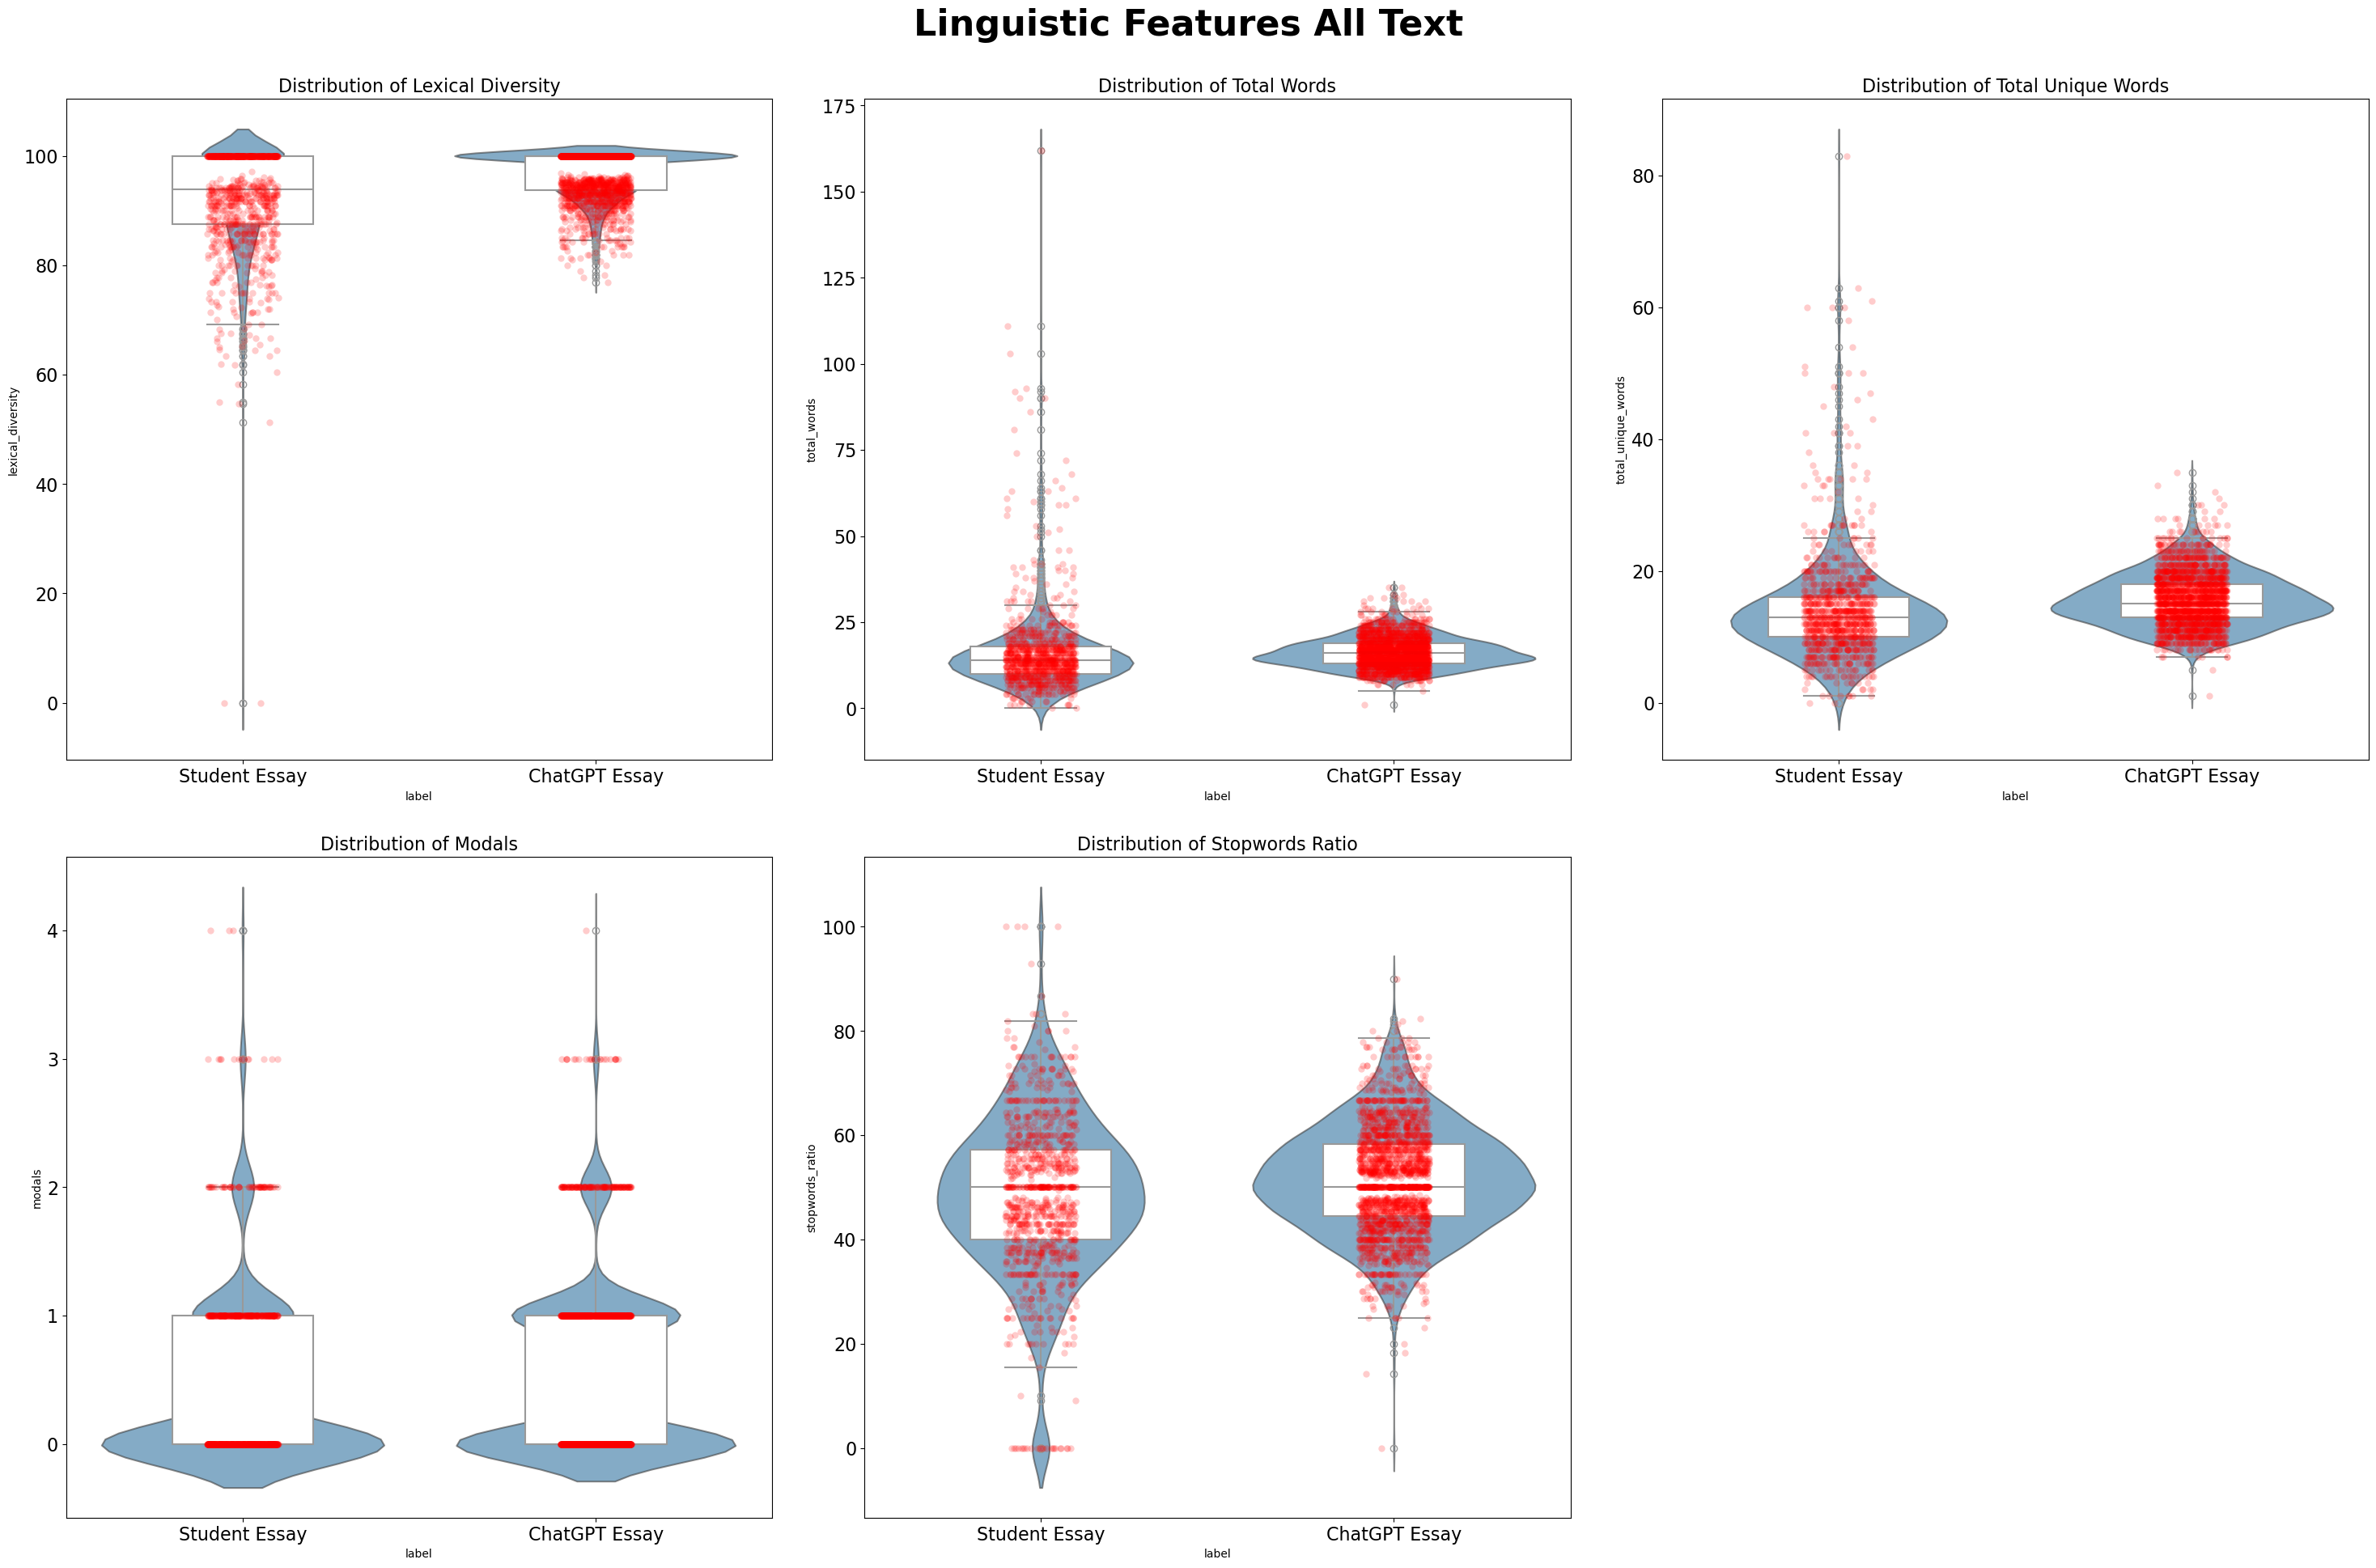

In [35]:
plt.figure(figsize=(30, 20))
for i, feature in enumerate([
    'lexical_diversity',
    'total_words',
    'total_unique_words',
    'modals',
    'stopwords_ratio',
]):
    plt.subplot(2, 3, i+1)
    sns.violinplot(x='label', y=feature, data=combined_features, inner=None, alpha=0.6, linewidth=1.5)
    sns.boxplot(x='label', y=feature, data=combined_features, width=0.4, 
                saturation=1, showfliers=True, color='white', linewidth=1.5)
    sns.stripplot(x='label', y=feature, data=combined_features, color='red', alpha=0.2, size=6, jitter=True, dodge=True)
    plt.title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

plt.suptitle('Linguistic Features All Text', fontsize=32, fontweight='bold', y=0.98)
plt.tight_layout(pad=3.0)

plt.savefig('ta_sentence/images/linguistic_features_comparison(all).png', dpi=300, bbox_inches='tight')

plt.show()


# Feature Extraction (Training, Validation, & Test Sets)

In [36]:
# Feature extraction for Student and ChatGPT essays
print("Features extraction for Student (training set)...")
std_tr_features = [linguistic_features(text) for text in train_set[train_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (training set)...")
gpt_tr_features = [linguistic_features(text) for text in train_set[train_set['label'] == 1]['text'].tolist()]

print("Features extraction for Student (validation set)...")
std_va_features = [linguistic_features(text) for text in val_set[val_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (validation set)...")
gpt_va_features = [linguistic_features(text) for text in val_set[val_set['label'] == 1]['text'].tolist()]

print("Features extraction for Student (test set)...")
std_te_features = [linguistic_features(text) for text in test_set[test_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (test set)...")
gpt_te_features = [linguistic_features(text) for text in test_set[test_set['label'] == 1]['text'].tolist()]

# convert
std_tr_features_df = pd.DataFrame(std_tr_features)
gpt_tr_features_df = pd.DataFrame(gpt_tr_features)

std_va_features_df = pd.DataFrame(std_va_features)
gpt_va_features_df = pd.DataFrame(gpt_va_features)

std_te_features_df = pd.DataFrame(std_te_features)
gpt_te_features_df = pd.DataFrame(gpt_te_features)

#Show the first few rows of the features DataFrames
print("\nStudent Linguistic Features (Test Set):")
display(std_te_features_df.head())

print("\nChatGPT Linguistic Features (Test Set):")
display(gpt_te_features_df.head())

Features extraction for Student (training set)...
Features extraction for ChatGPT (training set)...
Features extraction for Student (validation set)...
Features extraction for ChatGPT (validation set)...
Features extraction for Student (test set)...
Features extraction for ChatGPT (test set)...

Student Linguistic Features (Test Set):


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio
0,100.000000,8,8,0,37.500000
1,94.117647,17,16,0,41.176471
2,100.000000,8,8,1,37.500000
3,90.909091,22,20,0,36.363636
4,79.310345,29,23,1,44.827586



ChatGPT Linguistic Features (Test Set):


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio
0,100.00,10,10,1,70.000000
1,100.00,13,13,0,38.461538
2,100.00,14,14,0,50.000000
3,93.75,32,30,1,43.750000
4,100.00,19,19,1,57.894737


In [37]:
std_tr_features_df.shape, gpt_tr_features_df.shape, std_va_features_df.shape, gpt_va_features_df.shape, std_te_features_df.shape, gpt_te_features_df.shape

((766, 5), (767, 5), (52, 5), (51, 5), (205, 5), (1297, 5))

# Normalize Linguistic Features (Training, Validation, & Test Sets)

In [38]:
# Combine features into a single DataFrame
all_tr_features = pd.concat([std_tr_features_df, gpt_tr_features_df], axis=0)
all_va_features = pd.concat([std_va_features_df, gpt_va_features_df], axis=0)
all_te_features = pd.concat([std_te_features_df, gpt_te_features_df], axis=0)

# Normalize features
scaler = StandardScaler()
normalized_tr_features = scaler.fit_transform(all_tr_features)
normalized_va_features = scaler.fit_transform(all_va_features)
normalized_te_features = scaler.fit_transform(all_te_features)

# Separate normalized features back into student and ChatGPT
n_student_tr = len(std_tr_features_df)
n_chatgpt_tr = len(gpt_tr_features_df)

n_student_va = len(std_va_features_df)
n_chatgpt_va = len(gpt_va_features_df)

n_student_te = len(std_te_features_df)
n_chatgpt_te = len(gpt_te_features_df)

std_tr_features_norm = normalized_tr_features[:n_student_tr]
gpt_tr_features_norm = normalized_tr_features[n_student_tr:n_student_tr + n_chatgpt_tr]

std_va_features_norm = normalized_va_features[:n_student_va]
gpt_va_features_norm = normalized_va_features[n_student_va:n_student_va + n_chatgpt_va]

std_te_features_norm = normalized_te_features[:n_student_te]
gpt_te_features_norm = normalized_te_features[n_student_te:n_student_te + n_chatgpt_te]

print("Student features after normalization (training):")
print(std_tr_features_norm[:5])

print("ChatGPT features after normalization (training):")
print(gpt_tr_features_norm[:5])

Student features after normalization (training):
[[-0.96284022 -0.02078142 -0.14434444 -0.66244721  0.48717594]
 [-0.23864245 -0.2404912  -0.29908573  0.78624263  0.55432003]
 [ 0.24415607  1.29747727  1.86729221  2.23493246  0.28574368]
 [-1.20423948 -1.00947544 -1.3822747  -0.66244721 -3.74290168]
 [-0.50198709 -0.57005588 -0.76330957 -0.66244721 -1.69195495]]
ChatGPT features after normalization (training):
[[-0.02406533  0.19892836  0.3198794  -0.66244721  0.43495276]
 [-0.06824297  0.08907347  0.16513812  0.78624263  0.68070891]
 [ 0.72695458 -0.67991077 -0.76330957 -0.66244721 -1.48686028]
 [ 0.72695458 -0.13063631  0.01039684 -0.66244721  0.76918112]
 [ 0.72695458 -0.46020099 -0.45382701 -0.66244721 -1.23618901]]


# Visualize Linguistic Features (Data Test)

In [39]:
# Add labels to features
std_tr_features_df['label'] = 'Student Essay'
gpt_tr_features_df['label'] = 'ChatGPT Essay'

# Combine datasets
combined_tr_features = pd.concat([std_tr_features_df, gpt_tr_features_df], axis=0)

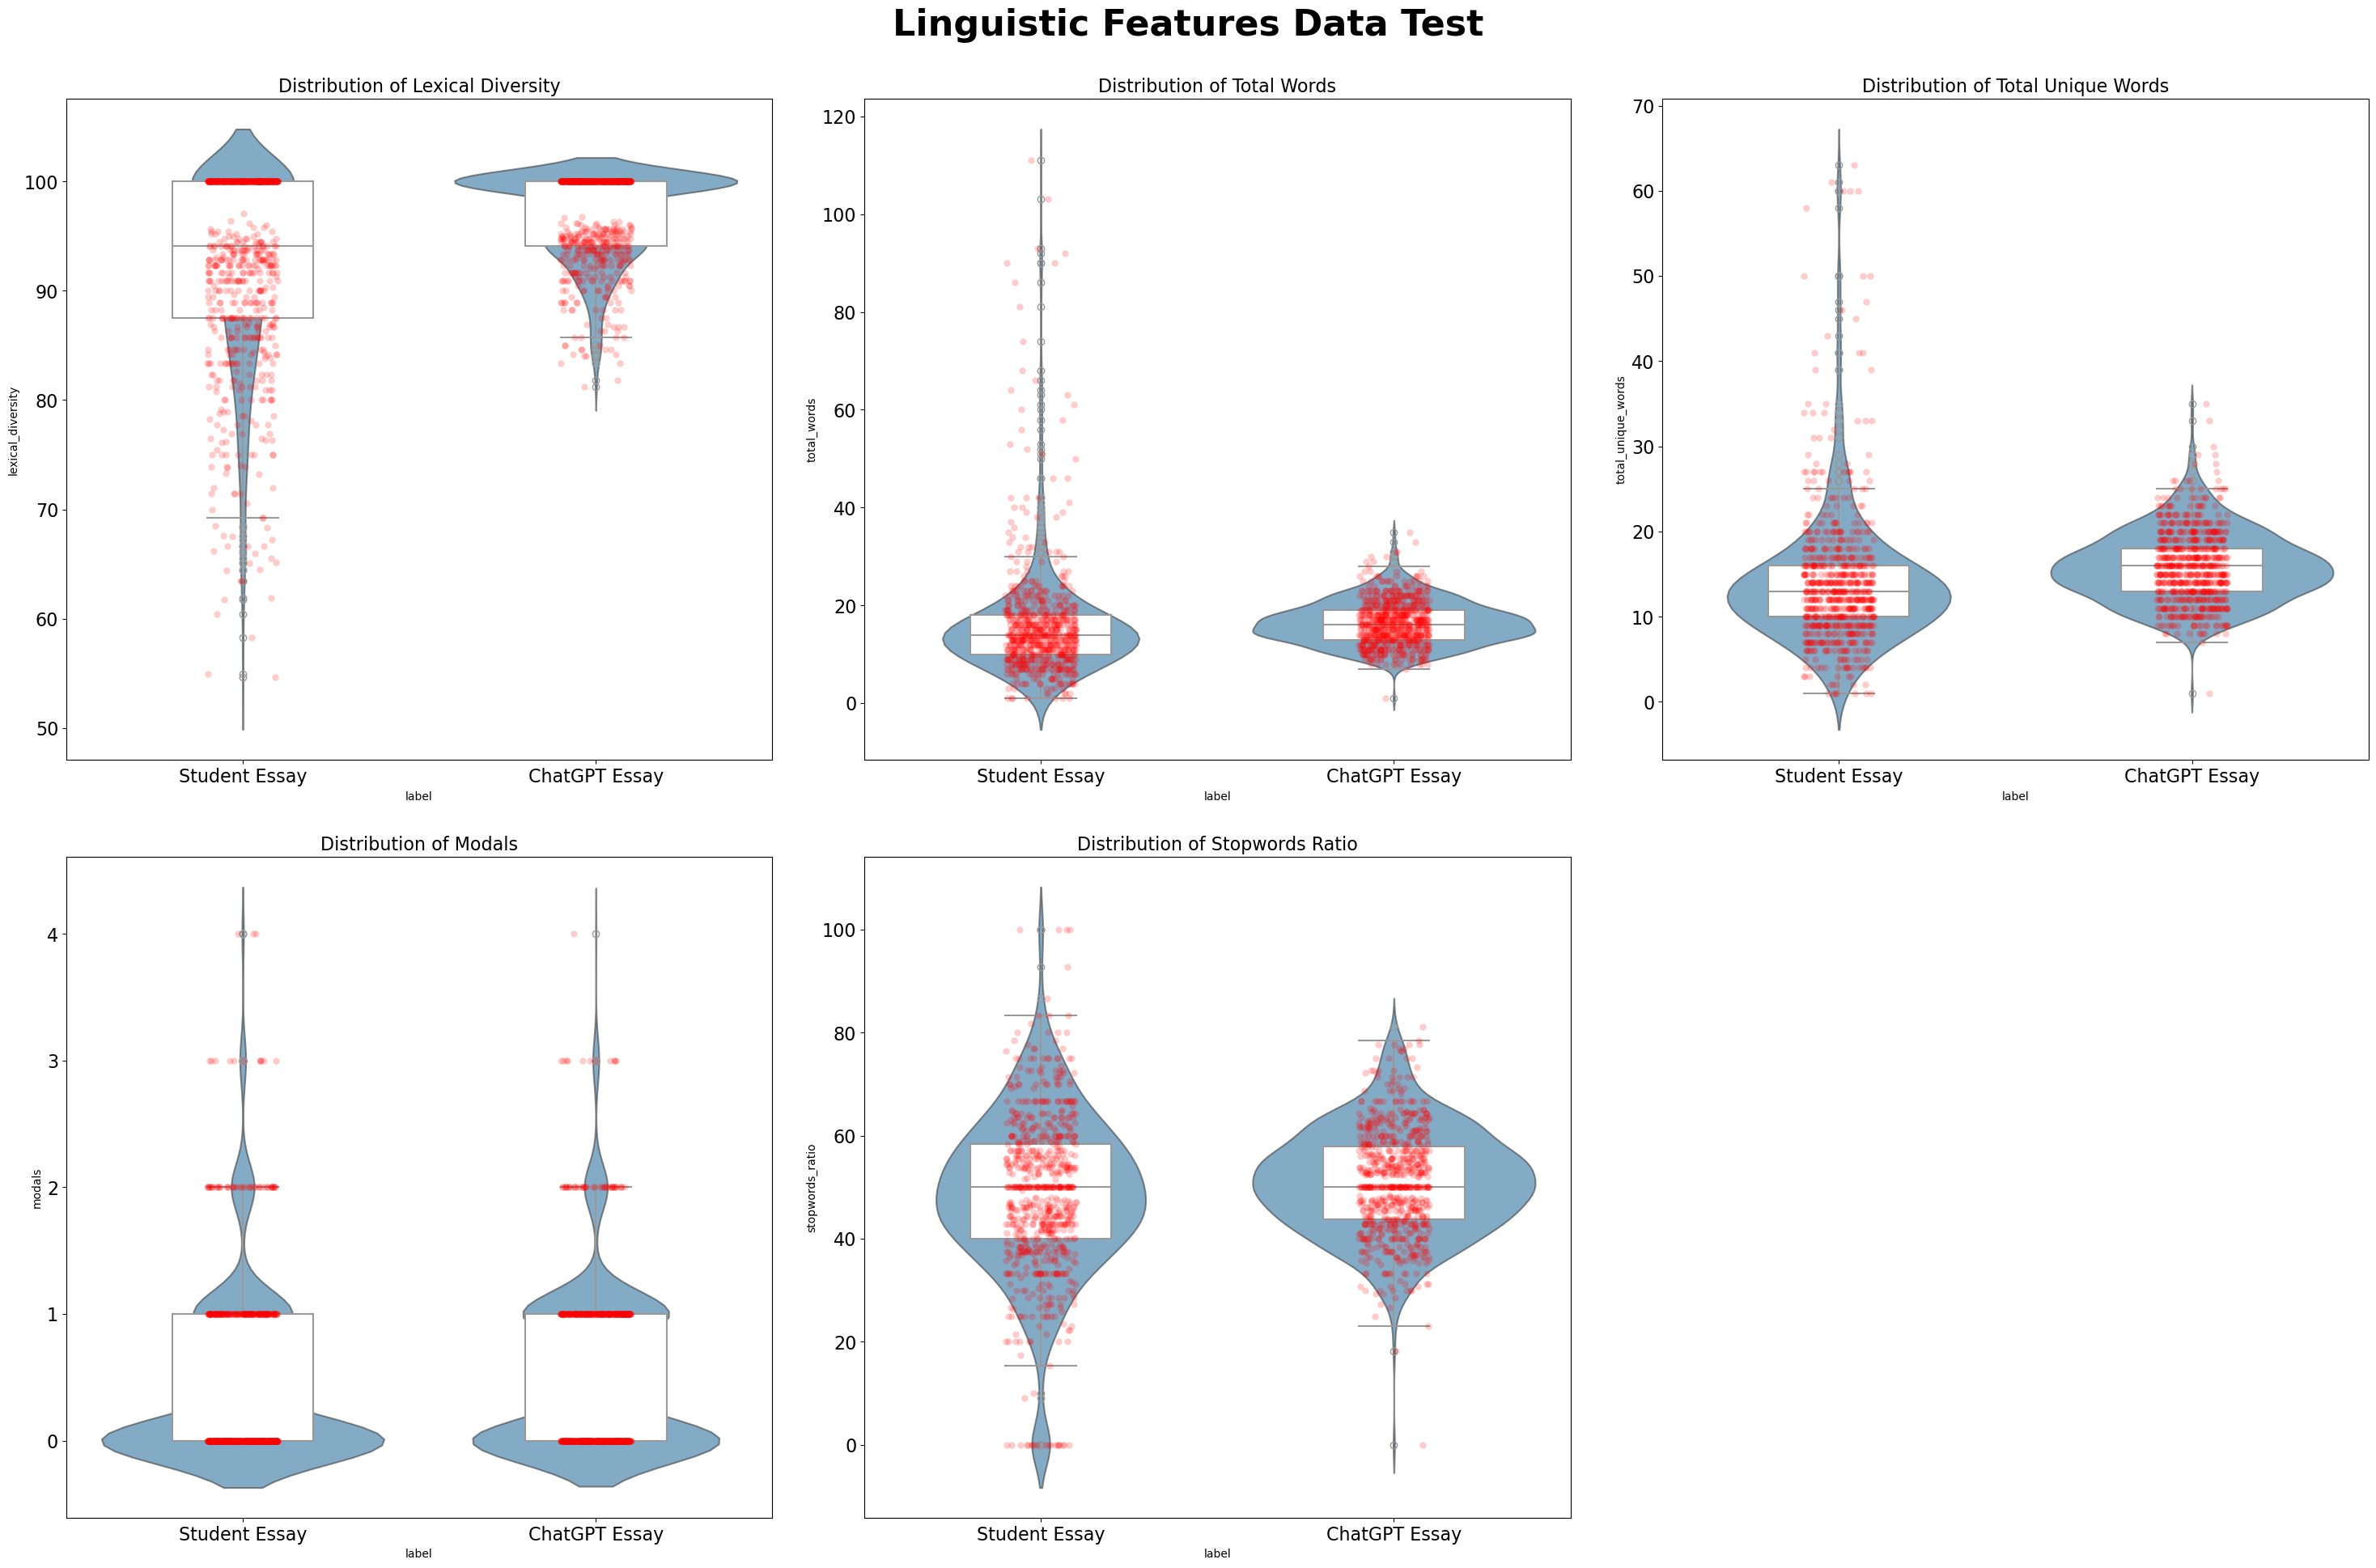

In [40]:
def new_func():
    plt.figure(figsize=(30, 20))
    for i, feature in enumerate([
    'lexical_diversity',
    'total_words',
    'total_unique_words',
    'modals',
    'stopwords_ratio',
]):
        plt.subplot(2, 3, i+1)
        sns.violinplot(x='label', y=feature, data=combined_tr_features, inner=None, alpha=0.6, linewidth=1.5)
        sns.boxplot(x='label', y=feature, data=combined_tr_features, width=0.4, 
                saturation=1, showfliers=True, color='white', linewidth=1.5)
        sns.stripplot(x='label', y=feature, data=combined_tr_features, color='red', alpha=0.2, size=6, jitter=True, dodge=True)
        plt.title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

new_func()

plt.suptitle('Linguistic Features Data Test', fontsize=32, fontweight='bold', y=0.98)
plt.tight_layout(pad=3.0)

plt.savefig('ta_sentence/images/linguistic_features_comparison(test).png', dpi=300, bbox_inches='tight')

plt.show()


In [41]:
# Check dimensions of your embedding arrays
print("std_te_emb shape:", std_te_emb.shape)
print("gpt_te_emb shape:", gpt_te_emb.shape)


# Print shapes of the resulting similarity scores
print("std_std_te_sim_scores shape:", np.array(std_std_te_sim_scores).shape)
print("std_gpt_te_sim_scores shape:", np.array(std_gpt_te_sim_scores).shape)
print("gpt_std_te_sim_scores shape:", np.array(gpt_std_te_sim_scores).shape)
print("gpt_gpt_te_sim_scores shape:", np.array(gpt_gpt_te_sim_scores).shape)

# Check shapes of the combined arrays
print("std_te_sim_scores shape:", std_te_sim_scores.shape)
print("gpt_te_sim_scores shape:", gpt_te_sim_scores.shape)

print("std_te_features_norm shape:", std_te_features_norm.shape)
print("gpt_te_features_norm shape:", gpt_te_features_norm.shape)

std_te_emb shape: (205, 128)
gpt_te_emb shape: (1297, 128)
std_std_te_sim_scores shape: (205,)
std_gpt_te_sim_scores shape: (205,)
gpt_std_te_sim_scores shape: (1297,)
gpt_gpt_te_sim_scores shape: (1297,)
std_te_sim_scores shape: (2, 205)
gpt_te_sim_scores shape: (2, 1297)
std_te_features_norm shape: (205, 5)
gpt_te_features_norm shape: (1297, 5)


# Data Preparation for Classification

In [42]:
# Combine embeddings for model 1 (already correct)
emb_tr_features = np.vstack([std_tr_emb, gpt_tr_emb])
emb_va_features = np.vstack([std_va_emb, gpt_va_emb])
emb_te_features = np.vstack([std_te_emb, gpt_te_emb])

std_tr_features_selected = std_tr_features_norm
gpt_tr_features_selected = gpt_tr_features_norm

std_va_features_selected = std_va_features_norm
gpt_va_features_selected = gpt_va_features_norm

std_te_features_selected = std_te_features_norm
gpt_te_features_selected = gpt_te_features_norm

linguistic_tr_features = np.vstack([
    std_tr_features_selected,
    gpt_tr_features_selected
])
linguistic_va_features = np.vstack([
    std_va_features_selected,
    gpt_va_features_selected
])
linguistic_te_features = np.vstack([
    std_te_features_selected,
    gpt_te_features_selected
])

std_tr_sim_scores_transposed = std_tr_sim_scores.T 
gpt_tr_sim_scores_transposed = gpt_tr_sim_scores.T
similarity_tr_scores = np.vstack([
    std_tr_sim_scores_transposed,
    gpt_tr_sim_scores_transposed,
])

std_va_sim_scores_transposed = std_va_sim_scores.T 
gpt_va_sim_scores_transposed = gpt_va_sim_scores.T
similarity_va_scores = np.vstack([
    std_va_sim_scores_transposed,
    gpt_va_sim_scores_transposed,
])
std_te_sim_scores_transposed = std_te_sim_scores.T 
gpt_te_sim_scores_transposed = gpt_te_sim_scores.T
similarity_te_scores = np.vstack([
    std_te_sim_scores_transposed,
    gpt_te_sim_scores_transposed,
])

# Create labels
std_tr_labels = np.zeros(len(train_set[train_set['label'] == 0]))
gpt_tr_labels = np.ones(len(train_set[train_set['label'] == 1]))
tr_labels = np.hstack([std_tr_labels, gpt_tr_labels])

# Validation set labels
std_va_labels = np.zeros(len(val_set[val_set['label'] == 0]))
gpt_va_labels = np.ones(len(val_set[val_set['label'] == 1]))
va_labels = np.hstack([std_va_labels, gpt_va_labels])

# Test set labels
std_te_labels = np.zeros(len(test_set[test_set['label'] == 0]))
gpt_te_labels = np.ones(len(test_set[test_set['label'] == 1]))
te_labels = np.hstack([std_te_labels, gpt_te_labels])

tr_labels = tr_labels.astype(int)
va_labels = va_labels.astype(int)
te_labels = te_labels.astype(int)

# Verify shapes
print(f"emb_te_features shape: {emb_te_features.shape}")
print(f"linguistic_te_features shape: {linguistic_te_features.shape}")
print(f"similarity_te_scores shape: {similarity_te_scores.shape}")
print(f"te_labels shape: {te_labels.shape}")

print(f"emb_te_features value: {emb_te_features[:5]}")
print(f"linguistic_te_features value: {linguistic_te_features[:5]}")
print(f"similarity_te_scores value: {similarity_te_scores[:5]}")
print(f"te_labels value: {te_labels[:5]}")


emb_te_features shape: (1502, 128)
linguistic_te_features shape: (1502, 5)
similarity_te_scores shape: (1502, 2)
te_labels shape: (1502,)
emb_te_features value: [[ 8.35661143e-02 -2.44338214e-01 -1.18773188e-02 -2.98391972e-02
   1.81173477e-02 -1.35470137e-01 -1.76505029e-01  8.48950297e-02
   2.79200356e-02 -3.03373691e-02 -1.20036036e-01  5.00169918e-02
  -1.34961054e-01 -1.76531091e-01 -5.19508310e-02 -1.55721633e-02
   2.27642339e-02 -6.98080063e-02  5.28812893e-02  8.94644484e-02
   4.93426584e-02 -3.35554183e-02  7.23136738e-02 -1.67214036e-01
  -3.30343880e-02 -6.89061135e-02 -1.72020242e-01 -1.58811565e-02
  -5.13596050e-02  5.28069474e-02 -2.85303611e-02 -1.06136486e-01
   1.07821509e-01  4.50423658e-02  1.59625392e-02  1.36584595e-01
  -1.87988102e-01 -1.64294168e-02  5.22818454e-02 -9.66735184e-02
   1.06117586e-02  8.84474516e-02  1.08642623e-01 -1.09122638e-02
   6.57980144e-02 -4.37919199e-02  6.71533644e-02 -8.36262777e-02
   1.24030806e-01 -1.83200818e-02 -8.07683077e-

# Build Classification Model

In [43]:
emb_input = tf.keras.layers.Input(
    shape=(128,),
    dtype=tf.float32, 
    name="embeddings"
)

sim_score_input = tf.keras.layers.Input(
    shape=(2,), 
    dtype=tf.float32, 
    name="similarity_score"
)

linguistic_input = tf.keras.layers.Input(
    shape=(5,),
    dtype=tf.float32, 
    name="linguistic_features"
)

emb_dense = tf.keras.layers.Dense(128, activation="relu")(emb_input)
sim_dense = tf.keras.layers.Dense(16, activation="relu")(sim_score_input)
lin_dense = tf.keras.layers.Dense(64, activation="relu")(linguistic_input)

combined = tf.keras.layers.Concatenate()([emb_dense, sim_dense, lin_dense])

x = tf.keras.layers.Dense(128, activation="relu")(combined)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

classifier = tf.keras.Model(
    inputs=[emb_input, sim_score_input, linguistic_input],
    outputs=output,
    name="text_classifier"
)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

classifier.summary()

Model: "text_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embeddings (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 similarity_score (InputLay  [(None, 2)]                  0         []                            
 er)                                                                                              
                                                                                                  
 linguistic_features (Input  [(None, 5)]                  0         []                            
 Layer)                                                                                           
                                                                                    

# Create Data Input for Classification

In [44]:
train_inputs = {
    "embeddings": emb_tr_features,
    "similarity_score": similarity_tr_scores,
    "linguistic_features": linguistic_tr_features
}

val_inputs = {
    "embeddings": emb_va_features,
    "similarity_score": similarity_va_scores,
    "linguistic_features": linguistic_va_features
}


test_inputs = {
    "embeddings": emb_te_features,
    "similarity_score": similarity_te_scores,
    "linguistic_features": linguistic_te_features
}

train_labels = tr_labels
val_labels = va_labels
test_labels = te_labels

# Train Classification Model

Training Classification Model...
Epoch 1/30
96/96 [==============================] - 3s 9ms/step - loss: 0.5811 - accuracy: 0.7750 - precision: 0.9668 - recall: 0.5698 - auc: 0.9477 - val_loss: 0.5113 - val_accuracy: 0.8252 - val_precision: 0.8667 - val_recall: 0.7647 - val_auc: 0.9063
Epoch 2/30
96/96 [==============================] - 1s 6ms/step - loss: 0.2743 - accuracy: 0.9667 - precision: 0.9786 - recall: 0.9544 - auc: 0.9921 - val_loss: 0.3996 - val_accuracy: 0.8350 - val_precision: 0.8696 - val_recall: 0.7843 - val_auc: 0.9110
Epoch 3/30
96/96 [==============================] - 1s 6ms/step - loss: 0.1098 - accuracy: 0.9713 - precision: 0.9725 - recall: 0.9700 - auc: 0.9956 - val_loss: 0.4688 - val_accuracy: 0.8350 - val_precision: 0.8696 - val_recall: 0.7843 - val_auc: 0.9112
Epoch 4/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0848 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9949 - val_loss: 0.5234 - val_accuracy: 0.8252 - val_precisio

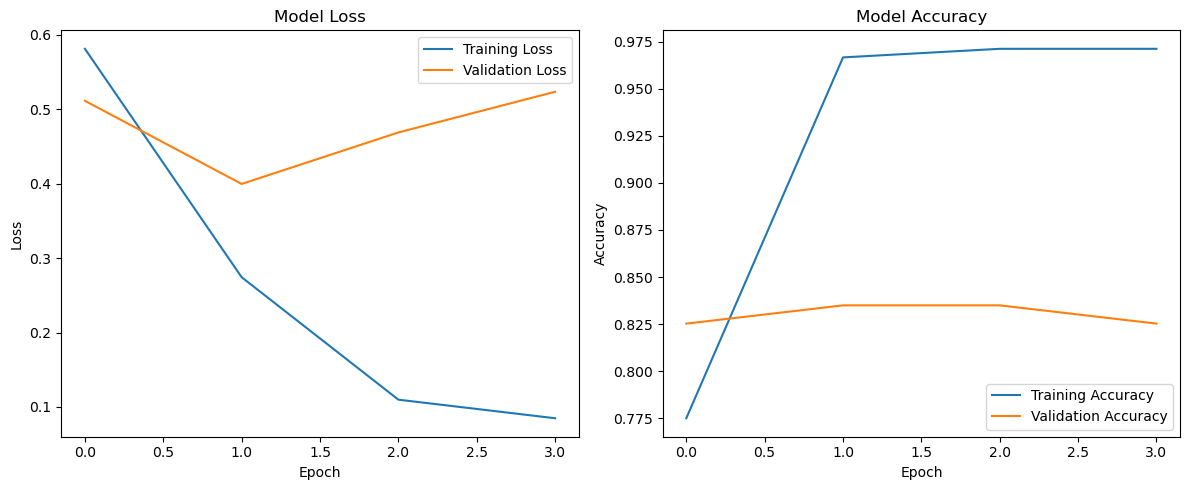

In [45]:
# Training classifier
print("Training Classification Model...")
history_classifier = classifier.fit(
    train_inputs,
    train_labels,
    validation_data=(val_inputs, val_labels),
    epochs=30,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluation Model

Making predictions on training and validation data...
52/52 [==============================] - 0s 2ms/step
Generating ROC curve...


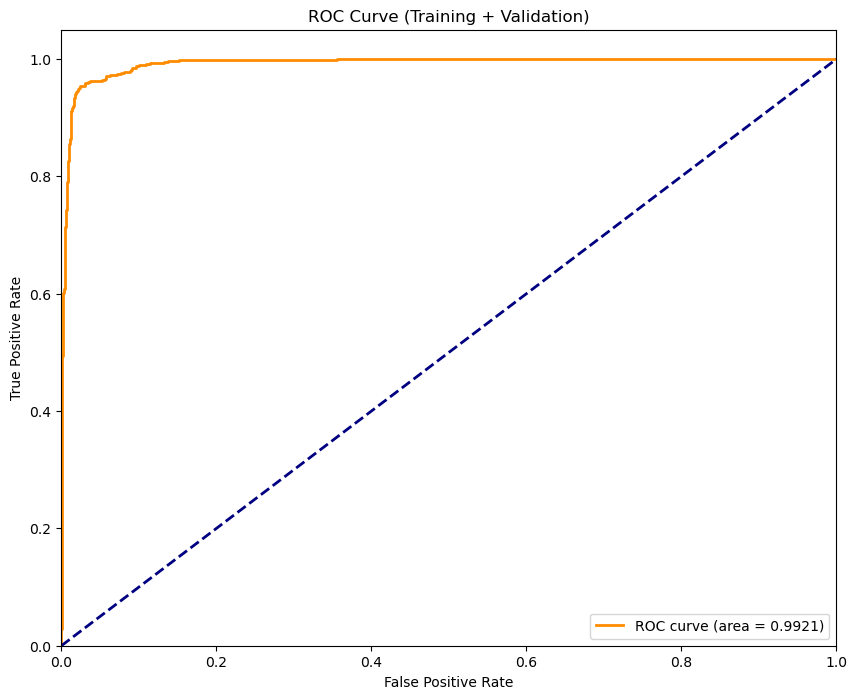

Analyzing threshold performance...


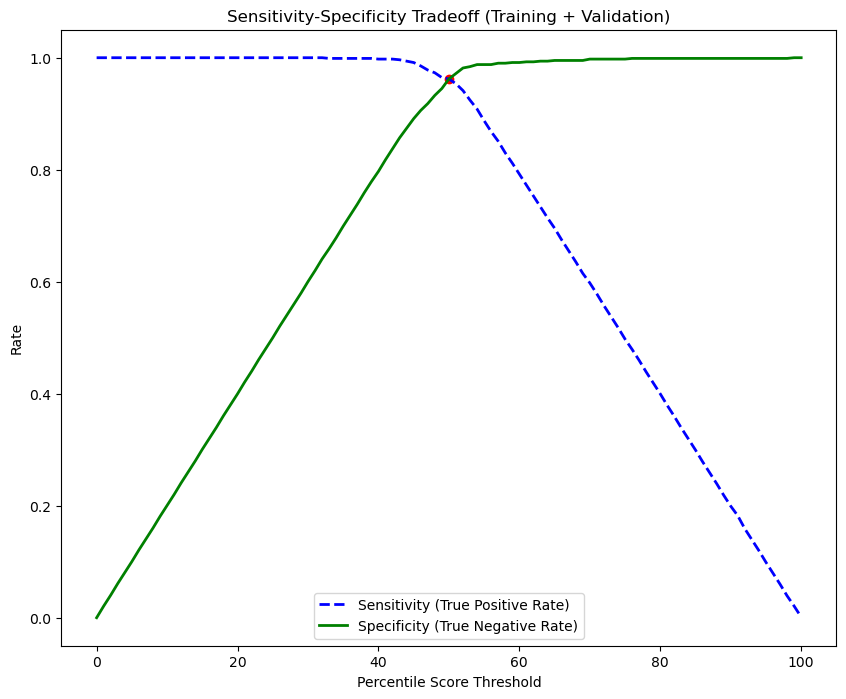

Threshold points with equal sensitivity and specificity:
Percentile: 50.0, Threshold: 0.4444, Rate: 0.9621
Selected optimal threshold: 0.4444


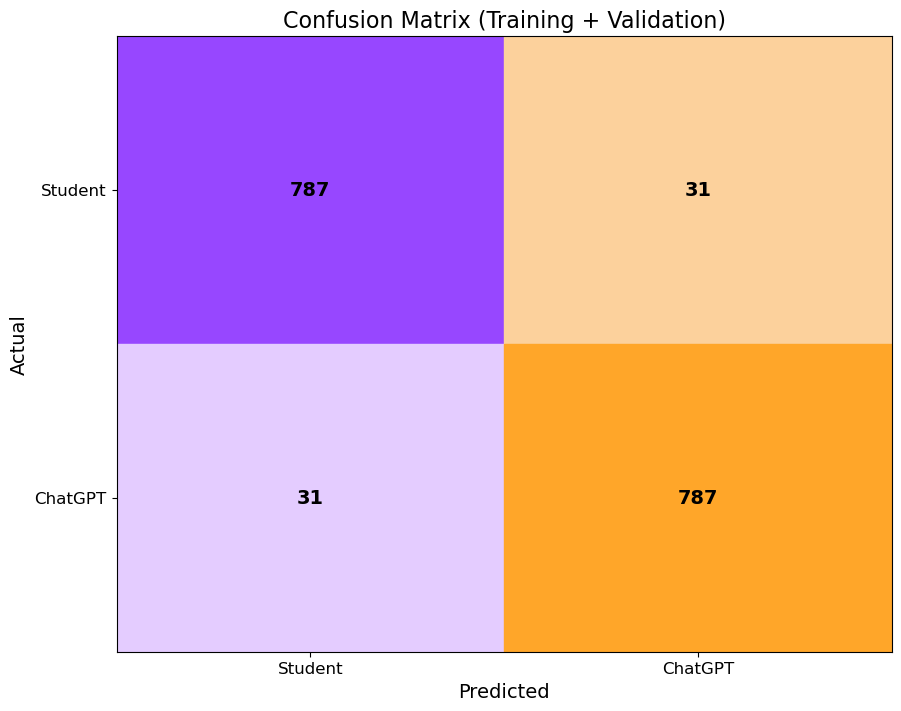


Detailed Classification Report (Training + Validation):
              precision    recall  f1-score   support

     Student       0.96      0.96      0.96       818
     ChatGPT       0.96      0.96      0.96       818

    accuracy                           0.96      1636
   macro avg       0.96      0.96      0.96      1636
weighted avg       0.96      0.96      0.96      1636



In [46]:
# Combine only training and validation inputs and labels (excluding test data)
combined_inputs = {
    "embeddings": np.concatenate([train_inputs["embeddings"], val_inputs["embeddings"]]),
    "similarity_score": np.concatenate([train_inputs["similarity_score"], val_inputs["similarity_score"]]),
    "linguistic_features": np.concatenate([train_inputs["linguistic_features"], val_inputs["linguistic_features"]])
}
combined_labels = np.concatenate([train_labels, val_labels])

# Make predictions on combined training and validation data
print("Making predictions on training and validation data...")
combined_predictions = classifier.predict(combined_inputs)

# Calculate ROC curve and plot
print("Generating ROC curve...")
fpr, tpr, _ = roc_curve(combined_labels, combined_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Training + Validation)')
plt.legend(loc="lower right")
plt.savefig('ta_sentence/images/roc_curve (train_val).png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate performance at different thresholds
print("Analyzing threshold performance...")
percentiles = np.linspace(0, 100, num=101)
sensitivity_data = []  
specificity_data = [] 
intersection_points = []

for p in percentiles:
    threshold = np.percentile(combined_predictions, p)
    predictions_binary = (combined_predictions >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(combined_labels, predictions_binary).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sensitivity_data.append(sensitivity)
    specificity_data.append(specificity)
    
    # Identify where sensitivity and specificity are approximately equal
    if np.isclose(sensitivity, specificity, atol=1e-2):
        intersection_points.append((p, threshold, sensitivity))

# Plot sensitivity-specificity tradeoff
plt.figure(figsize=(10, 8))
plt.plot(percentiles, sensitivity_data, label='Sensitivity (True Positive Rate)', color='blue', lw=2, linestyle='--')
plt.plot(percentiles, specificity_data, label='Specificity (True Negative Rate)', color='green', lw=2)

# Highlight balanced points
for p, threshold, rate in intersection_points:
    plt.scatter(p, rate, color='red')

plt.xlabel('Percentile Score Threshold')
plt.ylabel('Rate')
plt.title('Sensitivity-Specificity Tradeoff (Training + Validation)')
plt.legend(loc="best")
plt.savefig('ta_sentence/images/tradeoff_with_intersections (train_val).png', dpi=300, bbox_inches='tight')
plt.show()

print("Threshold points with equal sensitivity and specificity:")
for p, threshold, rate in intersection_points:
    print(f"Percentile: {p:.1f}, Threshold: {threshold:.4f}, Rate: {rate:.4f}")

if intersection_points:
    _, optimal_threshold, _ = intersection_points[0]
else:
    optimal_threshold = np.percentile(combined_predictions, 50)

print(f"Selected optimal threshold: {optimal_threshold:.4f}")

# Apply optimal threshold for final predictions
combined_predictions_binary = (combined_predictions >= optimal_threshold).astype(int)

# Generate confusion matrix with custom styling
cm_combined = confusion_matrix(combined_labels, combined_predictions_binary)

# Define custom colors for confusion matrix
colors = np.array([
    ["#9747FF", "#FCD19C"],  
    ["#E4CCFF", "#FFA629"]
])

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
rows, cols = cm_combined.shape
row_ind, col_ind = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

for i in range(rows):
    for j in range(cols):
        plt.fill_between([j, j+1], [rows-i-1, rows-i-1], [rows-i, rows-i], color=colors[i, j])
        plt.text(j+0.5, rows-i-0.5, str(cm_combined[i, j]), ha='center', va='center', 
                 color='black', fontsize=14, fontweight='bold')

plt.title('Confusion Matrix (Training + Validation)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks([0.5, 1.5], ['Student', 'ChatGPT'], fontsize=12)
plt.yticks([0.5, 1.5], ['ChatGPT', 'Student'], fontsize=12)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.savefig('ta_sentence/images/confusion_matrix(train_val).png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nDetailed Classification Report (Training + Validation):")
print(classification_report(combined_labels, combined_predictions_binary, target_names=['Student', 'ChatGPT']))

Making predictions on test dataset...
47/47 [==============================] - 0s 2ms/step


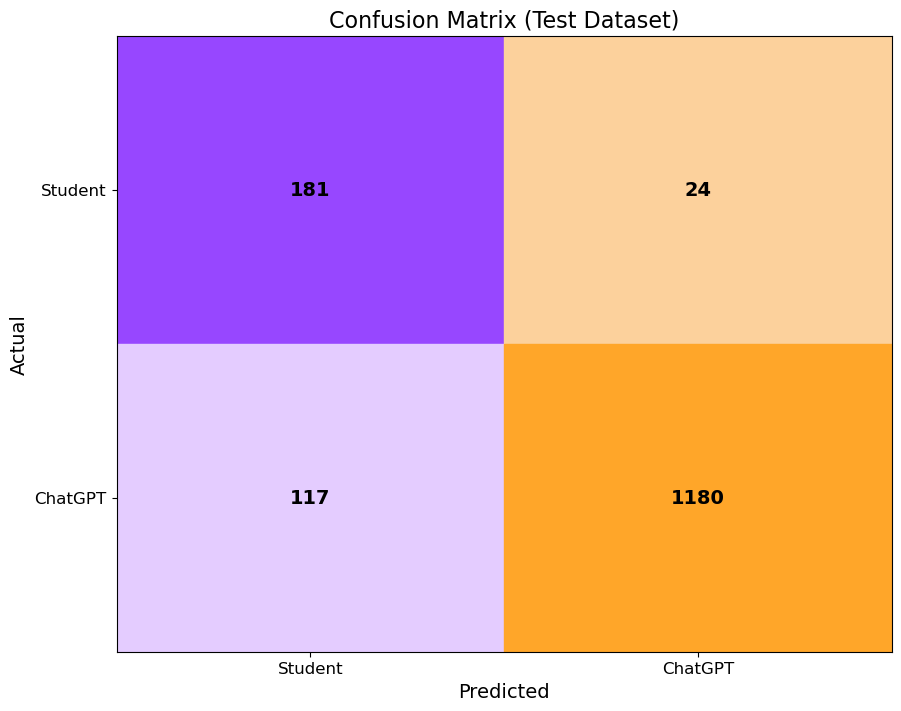


Detailed Classification Report (test set):
              precision    recall  f1-score   support

     Student       0.61      0.88      0.72       205
     ChatGPT       0.98      0.91      0.94      1297

    accuracy                           0.91      1502
   macro avg       0.79      0.90      0.83      1502
weighted avg       0.93      0.91      0.91      1502



In [47]:
# Make predictions on test data only
print("Making predictions on test dataset...")
test_predictions = classifier.predict(test_inputs)

test_predictions_binary = (test_predictions >= optimal_threshold).astype(int)

cm_test = confusion_matrix(test_labels, test_predictions_binary)

# Define custom colors for confusion matrix
colors = np.array([
    ["#9747FF", "#FCD19C"],  
    ["#E4CCFF", "#FFA629"]
])

# Visualize confusion matrix for test data
plt.figure(figsize=(10, 8))
rows, cols = cm_test.shape
row_ind, col_ind = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

for i in range(rows):
    for j in range(cols):
        plt.fill_between([j, j+1], [rows-i-1, rows-i-1], [rows-i, rows-i], color=colors[i, j])
        plt.text(j+0.5, rows-i-0.5, str(cm_test[i, j]), ha='center', va='center', 
                 color='black', fontsize=14, fontweight='bold')

plt.title('Confusion Matrix (Test Dataset)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks([0.5, 1.5], ['Student', 'ChatGPT'], fontsize=12)
plt.yticks([0.5, 1.5], ['ChatGPT', 'Student'], fontsize=12)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.savefig('ta_sentence/images/confusion_matrix (test set).png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report for test data
print("\nDetailed Classification Report (test set):")
print(classification_report(test_labels, test_predictions_binary, target_names=['Student', 'ChatGPT']))

# Misclassified Essay Report

In [48]:
misclassified_students = []
misclassified_chatgpt = []
test_actual_texts = test_set['text'].values
similarity_scores = test_inputs['similarity_score']

for i, (actual, pred) in enumerate(zip(test_labels, test_predictions_binary)):
    if actual == 0 and pred == 1:
        student_idx = i
        most_similar_chatgpt = None
        highest_similarity = -1
        avg_similarity_to_chatgpt = similarity_scores[i][1]
        for j, gpt_text in enumerate(gpt_sen):
            if j < len(gpt_te_emb):
                student_embedding = tf.expand_dims(std_te_emb[student_idx], 0) if student_idx < len(std_te_emb) else None
                chatgpt_embedding = tf.expand_dims(gpt_te_emb[j], 0)
                
                if student_embedding is not None:
                    similarity = cos_sim(student_embedding, chatgpt_embedding)
                    
                    if similarity > highest_similarity:
                        highest_similarity = similarity
                        most_similar_chatgpt = gpt_sen[j]
        
        misclassified_students.append({
            'Type': 'False Positive',
            'Text': test_actual_texts[i], 
            'Model Confidence': test_predictions[i][0],
            'Avg. Similarity': avg_similarity_to_chatgpt,
            'Most Similar Text': most_similar_chatgpt,
            'Similarity Score': highest_similarity
        })
    elif actual == 1 and pred == 0:
        chatgpt_idx = i
        most_similar_student = None
        highest_similarity = -1
        avg_similarity_to_student = similarity_scores[i][0]
        for j, std_text in enumerate(std_sen):
            if j < len(std_te_emb):
                chatgpt_embedding = tf.expand_dims(gpt_te_emb[chatgpt_idx-len(std_te_emb)], 0) if chatgpt_idx >= len(std_te_emb) else None
                student_embedding = tf.expand_dims(std_te_emb[j], 0)
                
                if chatgpt_embedding is not None:
                    similarity = cos_sim(chatgpt_embedding, student_embedding)
                    
                    if similarity > highest_similarity:
                        highest_similarity = similarity
                        most_similar_student = std_sen[j]
        
        misclassified_chatgpt.append({
            'Type': 'False Negative', 
            'Text': test_actual_texts[i], 
            'Model Confidence': 1 - test_predictions[i][0],
            'Avg. Similarity': avg_similarity_to_student,
            'Most Similar Text': most_similar_student,
            'Similarity Score': highest_similarity
        })

sorted_misclassified_students = sorted(
    misclassified_students, 
    key=lambda x: (x['Similarity Score'], x['Avg. Similarity'], x['Model Confidence']),
    reverse=True
)

sorted_misclassified_chatgpt = sorted(
    misclassified_chatgpt, 
    key=lambda x: (x['Similarity Score'], x['Avg. Similarity'], x['Model Confidence']),
    reverse=True
)

print("Top 3 Student Essays Misclassified as ChatGPT (by Similarity):")
display(pd.DataFrame(sorted_misclassified_students).head(3))

print("\nTop 2 ChatGPT Essays Misclassified as Student (by Similarity):")
display(pd.DataFrame(sorted_misclassified_chatgpt).head(2))

Top 3 Student Essays Misclassified as ChatGPT (by Similarity):


,Type,Text,Model Confidence,Avg. Similarity,Most Similar Text,Similarity Score
0,False Positive,"selain itu, saya juga menggunakan media sosial untuk membagikan momen-momen kebahagiaan saat idul fitri.",0.484683,0.054836,berbagai platform online seperti coursera dan youtube menawarkan banyak sekali kursus gratis yang sangat bermanfaat.,0.958769
1,False Positive,"bahkan, beberapa aplikasi belajar daring saya manfaatkan untuk menambah pengetahuan baru secara santai di sela-sela waktu berlibur.",0.907068,0.555884,"liburan kali ini mengingatkan saya bahwa meskipun teknik merayakan berubah, esensi dari idul fitri tidak hilang.",0.953049
2,False Positive,libur kali ini memberi saya waktu berkumpul lebih lama bersama keluarga.,0.927647,0.553781,"meski sempat khawatir rasanya tidak enak, ternyata hasilnya memuaskan dan membuat keluarga di rumah kagum.",0.925825



Top 2 ChatGPT Essays Misclassified as Student (by Similarity):


,Type,Text,Model Confidence,Avg. Similarity,Most Similar Text,Similarity Score
0,False Negative,"sebelum libur, saya dan keluarga memutuskan untuk merayakan lebaran di rumah kakek di kota lain.",0.949921,0.778650,saya berharap dapat terus memanfaatkan teknologi untuk meningkatkan kemampuan saya dan mencapai tujuan saya di masa depan.,0.982048
1,False Negative,"seperti kata pepatah, di balik setiap tantangan, selalu ada peluang.",0.956545,0.737214,"setelah solat subuh biasanya saya ngaji terlebih dahulu,setelah sy ngaji saya pergi nongkrong bersama teman teman dan bermain mobile legends bareng/mabar sampai jam 11.",0.960167


# Save Model

In [49]:
reference_embeddings = {
    'student': {
        'embeddings': std_emb,
        'similarity_scores': std_sim_scores
    },
    'chatgpt': {
        'embeddings': gpt_emb,
        'similarity_scores': gpt_sim_scores
    }
}

In [50]:
if not os.path.exists('ta_sentence'):
    os.makedirs('ta_sentence')

with open('ta_sentence/reference_embeddings.pkl', 'wb') as f:
    pickle.dump(reference_embeddings, f)

semantic_model.save('ta_sentence/semantic_model.h5')
classifier.save('ta_sentence/classification_model.h5')

tokenizer.save_pretrained('ta_sentence/tokenizer')

with open("ta_sentence/scaler_linguistic.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and configuration successfully saved!")

/home/training/anaconda3/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and configuration successfully saved!


In [51]:
%load_ext watermark
%watermark
%watermark -iv --gpu

Last updated: 2025-06-06T16:48:09.649832+07:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 24
Architecture: 64bit

tensorflow  : 2.19.0
numpy       : 1.26.4
pandas      : 2.2.2
transformers: 4.39.3
imblearn    : 0.12.3
re          : 2.2.1
sklearn     : 1.5.1
matplotlib  : 3.9.2
seaborn     : 0.13.2

GPU Info: 
  GPU 0: NVIDIA GeForce RTX 4060 Ti

